<font size = 15>Unindo os resultados das manipulações dos dados </font>

# Importando bibliotecas

In [1]:
# biblotecas para manipulação de dados
import pandas as pd
import numpy as np

#bibliotecas auxiliares
import os
import re
import matplotlib.pyplot as plt
from unidecode import unidecode
from functools import reduce
import itertools

#Biblioteca propria
import sys
sys.path.append("../src/")
from eda.eda import describe,print_df
from io_pyarrow.io_pyarrow import read_table_to_pandas,write_table_from_pandas #leitura e escrita de arquivos csv grandes

%matplotlib inline
%reload_ext watermark
%watermark --iversions

numpy     : 1.19.5
sys       : 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
json      : 2.0.9
matplotlib: 3.3.3
re        : 2.2.1
pandas    : 1.3.2



Definindo algumas funções para auxiliar na importação e controle dos arquivos já importados

In [2]:
PATH = "../data/interim/"
#Verificando todos os arquivos parquet
ARQUIVOS_PARQUET = [nome for nome in os.listdir(PATH) if re.search(".parquet$",nome) != None]
ARQUIVOS_PARQUET

['bpsp.parquet',
 'casos_agrupados.parquet',
 'casos_obitos_doencas_preexistentes.parquet',
 'cnesnet.parquet',
 'dados_covid_sp.parquet',
 'eistein.parquet',
 'exames_agrupados.parquet',
 'fleury.parquet',
 'fleury_analito.parquet',
 'fleury_exames.parquet',
 'hc.parquet',
 'hsl.parquet',
 'leitos_quantidadedes_totais.parquet',
 'obitos_FIOCRUZ.parquet',
 'obitos_raca_cor.parquet',
 'obitos_transparencia.parquet',
 'ocupacao_leitos.parquet',
 'plano_sp_leitos_internacoes.parquet',
 'raw_fleury_pacientes_exames.parquet',
 'respiradores.parquet']

In [3]:
resumo=pd.DataFrame({"Tabela":   ["dados_covid_sp","plano_sp_leitos_internacoes","obitos_raca_cor","obitos_transparencia","casos_obitos_doencas_preexistentes","ocupacao_leitos",                                                      "leitos_quantidadedes_totais","obitos_FIOCRUZ","respiradores","einstein",   "hc",        "hsl",       "bpsp",      "fleury"],
                     "data":     ["S",             "S",                          "N",              "N",                   "S",                                  "S",                                                                   "N",                          "S",             "S",            "S",         "S",         "S",         "S",         "S"],
                     "data_min": ["2020-02-25",    "2020-10-08",                 "",               "",                    "2020-02-04",                         "2020-01-01",                                                          "",                           "2020-03-27",    "2020-04-10",   "2019-11-01","2020-01-01","2020-02-26","2019-11-01","2019-11-01"],
                     "data_max": ["2021-04-27",    "2021-04-27",                 "",               "",                    "2021-04-26",                         "2021-05-30",                                                          "",                           "2021-05-06",    "2021-04-23",   "2020-08-11","2020-11-16","2020-12-29","2021-03-04","2020-12-15"],
                     "Ano":      ["S",             "S",                          "N",              "S",                   "S",                                  "S",                                                                   "S",                          "S",             "S",            "S",         "S",         "S",         "S",         "S"],
                     "municipio":["S",             "N",                          "S",              "N",                   "S",                                  "S",                                                                   "S",                          "S",             "N",            "S",         "S",         "S",         "S",         "S"],
                     "drs":      ["S",             "S",                          "S",              "N",                   "S",                                  "S",                                                                   "S",                          "S",             "N",            "S",         "S",         "S",         "S",         "S"],
                     "uf":       ["S",             "S",                          "S",              "S",                   "S",                                  "S",                                                                   "S",                          "S",             "N",            "S",         "S",         "S",         "S",         "S"],
                     "Obs":      ["",              "",                           "",               "",                    "Data do início dos sintomas",        "Existe CNES e não munip. Realizar join com leitos_quantidades_totais","Há o mês também",            "",              "",             "",          "",          "",          "",          ""]})
def color_style(val):
    color = "red" if val == "N" else "green" if val == "S" else "black"
    return 'color: %s' % color

resumo.data_min = pd.to_datetime(resumo.data_min)
resumo.data_max = pd.to_datetime(resumo.data_max)
resumo.style.applymap(color_style)

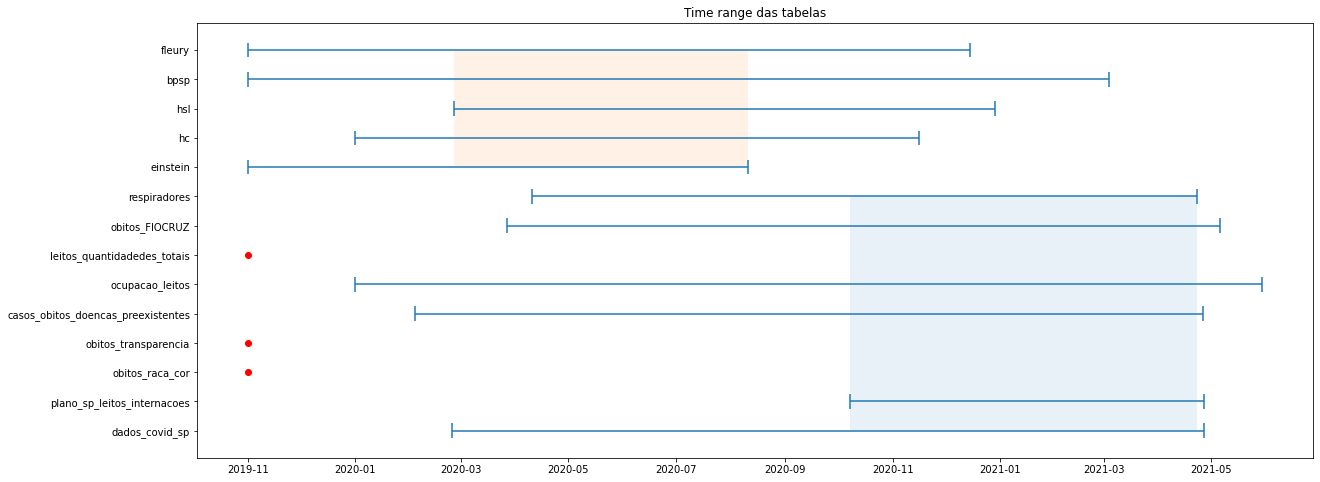

In [4]:
def plot_linha_range_data(Ax,datamin,datamax,y,vline_size=0.25):
    Ax.vlines(ymin=y-vline_size,ymax=y+vline_size,x = datamin)
    Ax.vlines(ymin=y-vline_size,ymax=y+vline_size,x = datamax)
    Ax.hlines(xmin=datamin,xmax=datamax,y=y)

def plot_range_data(df,fill=[]):
    _,Ax = plt.subplots(figsize = (20,8))
    for i,linha in df.iterrows():
        if(linha.data_min != linha.data_min):
            Ax.scatter(df.data_min.min(),i,c="red")
        else:
            plot_linha_range_data(Ax,linha.data_min,linha.data_max,i)

    for area in fill:
        Ax.fill_between(x = [df.query("Tabela == '%s'" % area["tabela_data_min"]).data_min.iloc[0],df.query("Tabela == '%s'" % area["tabela_data_max"]).data_max.iloc[0]],
                        y1 = [df.query("Tabela == '%s'" % area["tabela_y1"]).index[0]]*2,
                        y2 = [df.query("Tabela == '%s'" % area["tabela_y2"]).index[0]]*2,
                        alpha=0.1)

    Ax.set_yticks(range(df.shape[0]))
    Ax.set_yticklabels(df.Tabela.tolist())
    Ax.set_title("Time range das tabelas")
    plt.show()
    
plot_range_data(resumo,[{"tabela_data_min":"plano_sp_leitos_internacoes",
                         "tabela_data_max": "respiradores",
                         "tabela_y1": "respiradores",
                         "tabela_y2": "dados_covid_sp"},
                        {"tabela_data_min":"hsl",
                         "tabela_data_max": "einstein",
                         "tabela_y1": "fleury",
                         "tabela_y2": "einstein"}])

Caso tentemos unir todos os dados que não sejam de exames (cuja linha do tempo está em <font color = blue> azul</font>), teríamos uma perda muito grande por conta da base `plano_sp_leitos_internacoes`. Dessa forma, desconsiderando essa base de dados, conseguimos fazer o seguinte merge

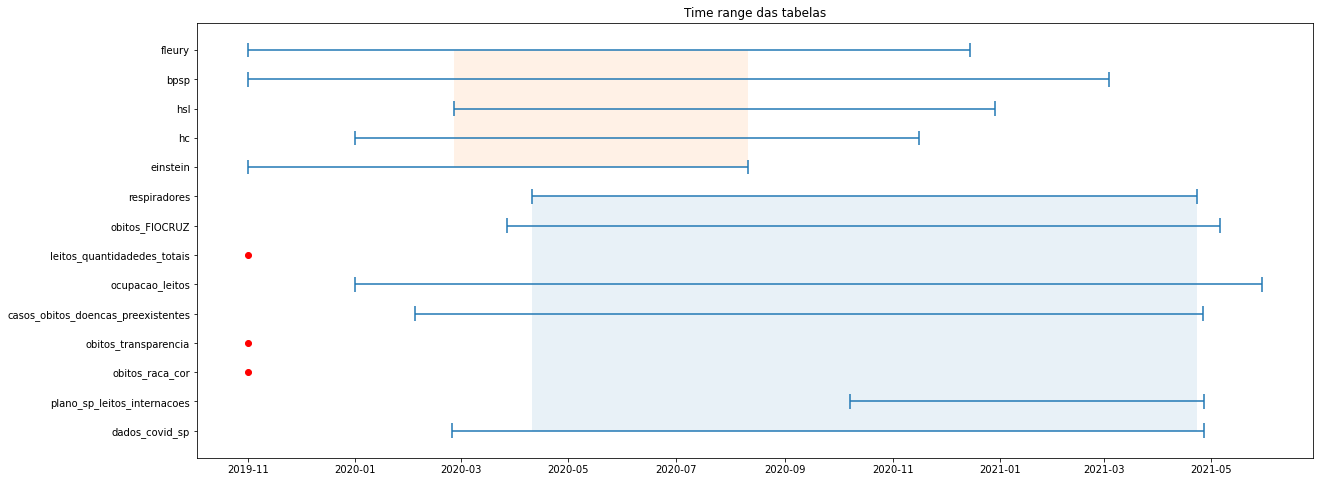

In [5]:
plot_range_data(resumo,[{"tabela_data_min":"respiradores",
                         "tabela_data_max": "respiradores",
                         "tabela_y1": "respiradores",
                         "tabela_y2": "dados_covid_sp"},
                        {"tabela_data_min":"hsl",
                         "tabela_data_max": "einstein",
                         "tabela_y1": "fleury",
                         "tabela_y2": "einstein"}])

In [6]:
#Como ocorrerão muitos merges, para não nos perdermos com os nomes das colunas e de qual tabela veio, vamos já definir prefixos padrões para cada tabela
def altera_nome_coluna(Colunas,Prefixo):
    return [Coluna + Prefixo for Coluna in Colunas]

#Função para facilitar a importação de arquivos
def leitura_arquivo_parquet(Nome_Arquivo):
    return read_table_to_pandas("%s%s%s" % (PATH,Nome_Arquivo,".parquet"))

# Função que cria um pipe entre a leitura dos arquivos e altera o nome das colunas dos arquivos importados
def leitura_arquivo_atualiza_importados(Nome_Arquivo,Sufixo_Coluna):
    Df = leitura_arquivo_parquet(Nome_Arquivo)
    Df.columns = altera_nome_coluna(Df.columns,Sufixo_Coluna)
    return Df

# Importando arquivos parquet

## Unindo *dados_sp* e *casos_obitos_doencas_preexistes*

In [7]:
dados_sp = leitura_arquivo_atualiza_importados("dados_covid_sp","_sp")
describe(dados_sp)

Quantidade de linhas: 276060


variable            type  na na_pct  unique                  min  \
0      nome_munic_sp          object   0   0.0%     645                    -   
1     codigo_ibge_sp         float64   0   0.0%     645            3500105.0   
2             dia_sp           int64   0   0.0%      31                    1   
3             mes_sp           int64   0   0.0%      12                    1   
4        datahora_sp  datetime64[ns]   0   0.0%     428  2020-02-25 00:00:00   
5           casos_sp           int64   0   0.0%   14356                    0   
6     casos_novos_sp           int64   0   0.0%     846                    0   
7        casos_pc_sp         float64   0   0.0%   14356                  0.0   
8      casos_mm7d_sp         float64   0   0.0%    2381                  0.0   
9          obitos_sp           int64   0   0.0%    2031                    0   
10   obitos_novos_sp           int64   0   0.0%     151                    0   
11      obitos_pc_sp         float64   0   0.0%    2031                  0.0   
12    obitos_mm7d_sp         float64   0   0.0%     454                  0.0   
13     letalidade_sp         float64   0   0.0%   45243                  0.0   
14        nome_ra_sp        category   0   0.0%      16                    -   
15         cod_ra_sp           int64   0   0.0%      16                    1   
16       nome_drs_sp        category   0   0.0%      17                    -   
17        cod_drs_sp           int64   0   0.0%      17                    1   
18            pop_sp           int64   0   0.0%     642                  812   
19         pop_60_sp           int64   0   0.0%     603                  130   
20        map_leg_sp          object   0   0.0%       8                    -   
21      map_leg_s_sp         float64   0   0.0%       8                  1.0   
22       latitude_sp         float64   0   0.0%     640             -25.0144   
23      longitude_sp         float64   0   0.0%     639             -53.0603   
24  semana_epidem_sp           int64   0   0.0%      53                    1   
25        perc_60_sp         float64   0   0.0%     645             0.082613   
26     Municípios_sp          object   0   0.0%     645                    -   
27           area_sp         float64   0   0.0%     645                3.612   
28      densi_pop_sp         float64   0   0.0%     645             3.825325   
29   densi_pop_60_sp         float64   0   0.0%     645             0.570283   

                 quat25               median                 mean  \
0                     -                    -                    -   
1             3514601.0            3528700.0        3528697.88062   
2                   8.0                 16.0            15.764019   
3                   3.0                  5.5             6.058411   
4   2020-06-10 18:00:00  2020-09-25 12:00:00  2020-09-25 12:00:00   
5                   9.0                119.0           1537.68927   
6                   0.0                  0.0             10.34432   
7               0.00009              0.00119             0.015377   
8                   0.0             0.857143            10.217294   
9                   0.0                  3.0            51.216993   
10                  0.0                  0.0             0.339933   
11                  0.0              0.00003             0.000512   
12                  0.0                  0.0             0.333772   
13                  0.0             0.019045             0.029784   
14                    -                    -                    -   
15                  4.0                  8.0             8.483721   
16                    -                    -                    -   
17                  5.0                  9.0             9.155039   
18               5534.0              13319.0         69209.145736   
19                928.0               2193.0         10591.786047   
20                    -                    -                    -   
21           

*casos_pre* necessita de um pre-processamento nos dados, pois cada registro da tabela representa uma pessoa. Para que conseguimos seguir com o conceito de município e data, precisamos agrupar os dados nesse formato

In [8]:
casos_pre = leitura_arquivo_atualiza_importados("casos_obitos_doencas_preexistentes","_pre")

#Para o caso de casos_pre, cada registro representa uma pessoa. Então precisamos fazer um tratamento previo para que possamos fazer o join
describe(casos_pre)

Quantidade de linhas: 2856225


variable            type     na na_pct  unique  \
0                nome_munic_pre          object    571  0.02%     645   
1               codigo_ibge_pre           int64      0   0.0%     646   
2                     idade_pre         float64   7074  0.25%     114   
3                   cs_sexo_pre        category   4711  0.16%       2   
4      data_inicio_sintomas_pre  datetime64[ns]  34679  1.21%     448   
5                     obito_pre           int64      0   0.0%       2   
6                      asma_pre        category      0   0.0%       3   
7               cardiopatia_pre        category      0   0.0%       3   
8                  diabetes_pre        category      0   0.0%       3   
9       doenca_hematologica_pre        category      0   0.0%       3   
10          doenca_hepatica_pre        category      0   0.0%       3   
11       doenca_neurologica_pre        category      0   0.0%       3   
12             doenca_renal_pre        category      0   0.0%       3   
13           imunodepressao_pre        category      0   0.0%       3   
14                obesidade_pre        category      0   0.0%       3   
15  outros_fatores_de_risco_pre        category      0   0.0%       3   
16              pneumopatia_pre        category      0   0.0%       3   
17                 puerpera_pre        category      0   0.0%       3   
18         sindrome_de_down_pre        category      0   0.0%       3   
19      totalmente_ignorado_pre            bool      0   0.0%       2   

                    min               quat25               median  \
0                     -                    -                    -   
1               3500105            3519071.0            3543402.0   
2                   0.0                 29.0                 40.0   
3                     -                    -                    -   
4   2020-02-04 00:00:00  2020-08-01 00:00:00  2020-12-06 00:00:00   
5                     0                  0.0                  0.0   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9                     -                    -                    -   
10                    -                    -                    -   
11                    -                    -                    -   
12                    -                    -                    -   
13                    -                    -                    -   
14                    -                    -                    -   
15                    -                    -                    -   
16                    -                    -                    -   
17                    -                    -                    -   
18                    -                    -                    -   
19                False                  1.0                  1.0   

                             mean               quat75                  max  \
0                               -                    -                    -   
1                    3535240.9102            3550308.0              3599999   
2                       41.576425                 53.0                115.0   
3                               -                    -                    -   
4   2020-11-11 12:26:32.961589504  2021-02-21 00:00:00  2021-04-26 00:00:00   
5                        0.032855                  0.0                    1   
6                               -                    -                    -   
7                               -                    -                    -   
8                               -                    -                    -   
9                               -                    -                    -   
10                              -                    -                    -   
11                              -                    -                    -   
12          

Primeiramente, vamos criar uma codificação para sexo (masculino e feminino) e se a pessoa morreu ou não. Depois disso, basta agrupar, por município e data e fazer a contagem de registros. __O caso particular será a idade, que nesse caso será a média__

In [9]:
# #Criando colunas para One Hot Encoding
# casos_pre = casos_pre.assign(sexo_f_pre = lambda x: np.where(x["cs_sexo_pre"] == 'feminino',1,0), #se for feminino, 1
#                              sexo_m_pre = lambda x: np.where(x["cs_sexo_pre"] == 'masculino',1,0), #se for masculino, 1
#                              obito_sim_pre = lambda x: np.where(x["obito_pre"] == 1,1,0), # se houve obito (obito == 1), 1
#                              obito_nao_pre = lambda x: np.where(x["obito_pre"] == 0,1,0)) # se não houve obito (obito == 0), 1

In [10]:
# #Vamos criar uma função de agregação para contar a quantidade de comorbidades no dia
# def contagem_comorbidade(series_groupby):
#     return series_groupby.apply(lambda x: 1 if x == "sim" else 0).sum()

In [10]:
#Vamos fazer um agrupamento em listas e aplicar as formulas de agrupamento em listas de informações, para nao perdemos as caracteristicas associadas às idades
to_list = lambda x: x.to_list()
casos_pre_ = casos_pre.groupby(["data_inicio_sintomas_pre","nome_munic_pre"]).agg({"codigo_ibge_pre":"first", #pegar o primeiro registro, pois será igual em todos os casos
                                                                                  "idade_pre": to_list, #lista da idade das pessoas
                                                                                  "cs_sexo_pre": to_list, # o sexo dos contaminados
                                                                                  "obito_pre": to_list, #se a pessoa veio a obito ou nao
                                                                                  "asma_pre" : to_list, #daqueles pacientes, havia alguem com asma?
                                                                                  "cardiopatia_pre": to_list,
                                                                                  "diabetes_pre": to_list,
                                                                                  "doenca_hematologica_pre": to_list,
                                                                                  "doenca_hepatica_pre": to_list,
                                                                                  "doenca_neurologica_pre": to_list,
                                                                                  "doenca_renal_pre": to_list,
                                                                                  "imunodepressao_pre": to_list,
                                                                                  "obesidade_pre": to_list,
                                                                                  "outros_fatores_de_risco_pre": to_list,
                                                                                  "pneumopatia_pre": to_list,
                                                                                  "puerpera_pre": to_list,
                                                                                  "sindrome_de_down_pre": to_list
                                                                                  }).reset_index()

In [11]:
#Vamos exportar o dataset pois o groupby é demorado para concluir
write_table_from_pandas(casos_pre_,"../data/interim/produto_join/casos_pre.parquet")

In [12]:
casos_pre_ =read_table_to_pandas("../data/interim/produto_join/casos_pre.parquet")
describe(casos_pre_)

Quantidade de linhas: 158601


variable            type  na na_pct unique  \
0      data_inicio_sintomas_pre  datetime64[ns]   0   0.0%    448   
1                nome_munic_pre          object   0   0.0%    645   
2               codigo_ibge_pre           int64   0   0.0%    645   
3                     idade_pre          object   0   0.0%      -   
4                   cs_sexo_pre          object   0   0.0%      -   
5                     obito_pre          object   0   0.0%      -   
6                      asma_pre          object   0   0.0%      -   
7               cardiopatia_pre          object   0   0.0%      -   
8                  diabetes_pre          object   0   0.0%      -   
9       doenca_hematologica_pre          object   0   0.0%      -   
10          doenca_hepatica_pre          object   0   0.0%      -   
11       doenca_neurologica_pre          object   0   0.0%      -   
12             doenca_renal_pre          object   0   0.0%      -   
13           imunodepressao_pre          object   0   0.0%      -   
14                obesidade_pre          object   0   0.0%      -   
15  outros_fatores_de_risco_pre          object   0   0.0%      -   
16              pneumopatia_pre          object   0   0.0%      -   
17                 puerpera_pre          object   0   0.0%      -   
18         sindrome_de_down_pre          object   0   0.0%      -   

                    min               quat25               median  \
0   2020-02-04 00:00:00  2020-08-01 00:00:00  2020-11-08 00:00:00   
1                     -                    -                    -   
2               3500105            3514205.0            3527405.0   
3                     -                    -                    -   
4                     -                    -                    -   
5                     -                    -                    -   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9                     -                    -                    -   
10                    -                    -                    -   
11                    -                    -                    -   
12                    -                    -                    -   
13                    -                    -                    -   
14                    -                    -                    -   
15                    -                    -                    -   
16                    -                    -                    -   
17                    -                    -                    -   
18                    -                    -                    -   

                             mean               quat75                  max  \
0   2020-10-31 01:33:47.404619264  2021-02-04 00:00:00  2021-04-26 00:00:00   
1                               -                    -                    -   
2                  3528443.416473            3542909.0              3557303   
3                               -                    -                    -   
4                               -                    -                    -   
5                               -                    -                    -   
6                               -                    -                    -   
7                               -                    -                    -   
8                               -                    -                    -   
9                               -                    -                    -   
10                              -                    -                    -   
11                              -                    -                    -   
12                              -                    -                    -   
13                              -                    -                    -   
14                              -                    -                    - 

Nesse caso, conseguimos juntar as bases, contudo, precisamos fazer o mapeamento das cidades presentes na base *casos_pre_* com a informação `nome_drs`

In [13]:
#Vamos fazer um merge com dados_sp
dados=dados_sp.merge(casos_pre_,
            how = 'left',
            right_on = ["data_inicio_sintomas_pre","nome_munic_pre"],
            left_on = ["datahora_sp","nome_munic_sp"]).drop(columns = ["data_inicio_sintomas_pre","nome_munic_pre"])
describe(dados)

Quantidade de linhas: 276060


variable            type      na  na_pct unique  \
0                 nome_munic_sp          object       0    0.0%    645   
1                codigo_ibge_sp         float64       0    0.0%    645   
2                        dia_sp           int64       0    0.0%     31   
3                        mes_sp           int64       0    0.0%     12   
4                   datahora_sp  datetime64[ns]       0    0.0%    428   
5                      casos_sp           int64       0    0.0%  14356   
6                casos_novos_sp           int64       0    0.0%    846   
7                   casos_pc_sp         float64       0    0.0%  14356   
8                 casos_mm7d_sp         float64       0    0.0%   2381   
9                     obitos_sp           int64       0    0.0%   2031   
10              obitos_novos_sp           int64       0    0.0%    151   
11                 obitos_pc_sp         float64       0    0.0%   2031   
12               obitos_mm7d_sp         float64       0    0.0%    454   
13                letalidade_sp         float64       0    0.0%  45243   
14                   nome_ra_sp        category       0    0.0%     16   
15                    cod_ra_sp           int64       0    0.0%     16   
16                  nome_drs_sp        category       0    0.0%     17   
17                   cod_drs_sp           int64       0    0.0%     17   
18                       pop_sp           int64       0    0.0%    642   
19                    pop_60_sp           int64       0    0.0%    603   
20                   map_leg_sp          object       0    0.0%      8   
21                 map_leg_s_sp         float64       0    0.0%      8   
22                  latitude_sp         float64       0    0.0%    640   
23                 longitude_sp         float64       0    0.0%    639   
24             semana_epidem_sp           int64       0    0.0%     53   
25                   perc_60_sp         float64       0    0.0%    645   
26                Municípios_sp          object       0    0.0%    645   
27                      area_sp         float64       0    0.0%    645   
28                 densi_pop_sp         float64       0    0.0%    645   
29              densi_pop_60_sp         float64       0    0.0%    645   
30              codigo_ibge_pre         float64  117845  42.69%    645   
31                    idade_pre          object  117845  42.69%      -   
32                  cs_sexo_pre          object  117845  42.69%      -   
33                    obito_pre          object  117845  42.69%      -   
34                     asma_pre          object  117845  42.69%      -   
35              cardiopatia_pre          object  117845  42.69%      -   
36                 diabetes_pre          object  117845  42.69%      -   
37      doenca_hematologica_pre          object  117845  42.69%      -   
38          doenca_hepatica_pre          object  117845  42.69%      -   
39       doenca_neurologica_pre          object  117845  42.69%      -   
40             doenca_renal_pre          object  117845  42.69%      -   
41           imunodepressao_pre          object  117845  42.69%      -   
42                obesidade_pre          object  117845  42.69%      -   
43  outros_fatores_de_risco_pre          object  117845  42.69%      -   
44              pneumopatia_pre          object  117845  42.69%      -   
45                 puerpera_pre          object  117845  42.69%      -   
46         sindrome_de_down_pre          object  117845  42.69%      -   

                    min               quat25               median  \
0                     -                    -                    -   
1             3500105.0            3514601.0            3528700.0   
2                     1                  8.0                 16.0   
3                     1                  3.0                  5.5   
4   2020-02-25 00:00:00  2020-06-10 18:00:00  2020-09-25 12:00:00   
5                     0                  9.0            

In [14]:
#Notamos que existe dados nulos quando fazemos o merge. Vamos verificar o motivo
casos_pre_[(casos_pre_["nome_munic_pre"] == "Estiva Gerbi") & 
           (casos_pre_["data_inicio_sintomas_pre"] >= '2021-04-10') & 
           (casos_pre_["data_inicio_sintomas_pre"] <= '2021-04-30')]

data_inicio_sintomas_pre nome_munic_pre  codigo_ibge_pre  \
152627               2021-04-10   Estiva Gerbi          3557303   
153104               2021-04-11   Estiva Gerbi          3557303   
153570               2021-04-12   Estiva Gerbi          3557303   
154053               2021-04-13   Estiva Gerbi          3557303   
154496               2021-04-14   Estiva Gerbi          3557303   
154942               2021-04-15   Estiva Gerbi          3557303   
155398               2021-04-16   Estiva Gerbi          3557303   
155831               2021-04-17   Estiva Gerbi          3557303   

                 idade_pre                        cs_sexo_pre  obito_pre  \
152627        [55.0, 30.0]               [feminino, feminino]     [0, 0]   
153104        [82.0, 38.0]             [masculino, masculino]     [1, 0]   
153570  [20.0, 34.0, 34.0]  [masculino, masculino, masculino]  [0, 0, 0]   
154053              [36.0]                         [feminino]        [0]   
154496              [20.0]                         [feminino]        [0]   
154942              [82.0]                        [masculino]        [0]   
155398              [23.0]                        [masculino]        [0]   
155831  [19.0, 47.0, 29.0]     [feminino, feminino, feminino]  [0, 0, 0]   

                              asma_pre                 cardiopatia_pre  \
152627            [ignorado, ignorado]            [ignorado, ignorado]   
153104                 [não, ignorado]                 [sim, ignorado]   
153570  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   
154053                      [ignorado]                      [ignorado]   
154496                      [ignorado]                      [ignorado]   
154942                      [ignorado]                      [ignorado]   
155398                      [ignorado]                      [ignorado]   
155831  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   

                          diabetes_pre         doenca_hematologica_pre  \
152627            [ignorado, ignorado]            [ignorado, ignorado]   
153104                 [não, ignorado]                 [não, ignorado]   
153570  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   
154053                      [ignorado]                      [ignorado]   
154496                      [ignorado]                      [ignorado]   
154942                      [ignorado]                      [ignorado]   
155398                      [ignorado]                      [ignorado]   
155831  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   

                   doenca_hepatica_pre          doenca_neurologica_pre  \
152627            [ignorado, ignorado]            [ignorado, ignorado]   
153104                 [não, ignorado]                 [sim, ignorado]   
153570  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   
154053                      [ignorado]                      [ignorado]   
154496                      [ignorado]                      [ignorado]   
154942                      [ignorado]                      [ignorado]   
155398                      [ignorado]                      [ignorado]   
155831  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   

                      doenca_renal_pre              imunodepressao_pre  \
152627            [ignorado, ignorado]            [ignorado, ignorado]   
153104                 [não, ignorado]                      [não, sim]   
153570  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   
154053                      [ignorado]                      [ignorado]   
154496                      [ignorado]                      [ignorado]   
154942                      [ignorado]                      [ignorado]   
155398                      [ignorado]                      [ignorado]   
155831  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   

                         obesidade_pre     outros_

In [15]:
dados[(dados["nome_munic_sp"] == "Estiva Gerbi") & 
      (dados["datahora_sp"] >= '2021-04-10') & 
      (dados["datahora_sp"] <= '2021-04-30')]

nome_munic_sp  codigo_ibge_sp  dia_sp  mes_sp datahora_sp  casos_sp  \
276042  Estiva Gerbi       3557303.0      10       4  2021-04-10       491   
276043  Estiva Gerbi       3557303.0      11       4  2021-04-11       491   
276044  Estiva Gerbi       3557303.0      12       4  2021-04-12       491   
276045  Estiva Gerbi       3557303.0      13       4  2021-04-13       493   
276046  Estiva Gerbi       3557303.0      14       4  2021-04-14       494   
276047  Estiva Gerbi       3557303.0      15       4  2021-04-15       498   
276048  Estiva Gerbi       3557303.0      16       4  2021-04-16       509   
276049  Estiva Gerbi       3557303.0      17       4  2021-04-17       509   
276050  Estiva Gerbi       3557303.0      18       4  2021-04-18       511   
276051  Estiva Gerbi       3557303.0      19       4  2021-04-19       511   
276052  Estiva Gerbi       3557303.0      20       4  2021-04-20       519   
276053  Estiva Gerbi       3557303.0      21       4  2021-04-21       524   
276054  Estiva Gerbi       3557303.0      22       4  2021-04-22       524   
276055  Estiva Gerbi       3557303.0      23       4  2021-04-23       524   
276056  Estiva Gerbi       3557303.0      24       4  2021-04-24       529   
276057  Estiva Gerbi       3557303.0      25       4  2021-04-25       529   
276058  Estiva Gerbi       3557303.0      26       4  2021-04-26       529   
276059  Estiva Gerbi       3557303.0      27       4  2021-04-27       532   

        casos_novos_sp  casos_pc_sp  casos_mm7d_sp  obitos_sp  ...  \
276042               1      0.00491       3.714286         16  ...   
276043               0      0.00491       3.571429         17  ...   
276044               0      0.00491       3.571429         17  ...   
276045               2      0.00493       2.857143         17  ...   
276046               1      0.00494       2.000000         17  ...   
276047               4      0.00498       2.285714         17  ...   
276048              11      0.00509       2.714286         18  ...   
276049               0      0.00509       2.571429         18  ...   
276050               2      0.00511       2.857143         19  ...   
276051               0      0.00511       2.857143         19  ...   
276052               8      0.00519       3.714286         19  ...   
276053               5      0.00524       4.285714         19  ...   
276054               0      0.00524       3.714286         19  ...   
276055               0      0.00524       2.142857         19  ...   
276056               5      0.00529       2.857143         20  ...   
276057               0      0.00529       2.571429         20  ...   
276058               0      0.00529       2.571429         20  ...   
276059               3      0.00532       1.857143         21  ...   

               doenca_hematologica_pre             doenca_hepatica_pre  \
276042            [ignorado, ignorado]            [ignorado, ignorado]   
276043                 [não, ignorado]                 [não, ignorado]   
276044  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   
276045                      [ignorado]                      [ignorado]   
276046                      [ignorado]                      [ignorado]   
276047                      [ignorado]                      [ignorado]   
276048                      [ignorado]                      [ignorado]   
276049  [ignorado, ignorado, ignorado]  [ignorado, ignorado, ignorado]   
276050                             NaN                             NaN   
276051                             NaN                             NaN   
276052                             NaN                             NaN   
276053                             NaN                             NaN   
276054                             NaN                             NaN   
276055                             NaN                             NaN   
276056                             NaN                             NaN   
276057   

O que podemos perceber é que, como a base de casos tem como a data referenciando o inicio dos sintomas, enquanto que a base de dados de covid de SP indica a data corrente, pode haver um atraso entre o início dos sintomas indicado pelo paciente e a constatação de um novo caso, dado que os testes necessitam que o paciente aguarde alguns dias (de 2 a 8) para que o resultado seja efetivo<br>

In [13]:
# colunas_casos_na = ['cs_sexo_pre', 'obito_pre',
#                    'asma_pre', 'cardiopatia_pre', 'diabetes_pre',
#                    'doenca_hematologica_pre', 'doenca_hepatica_pre',
#                    'doenca_neurologica_pre', 'doenca_renal_pre', 'imunodepressao_pre',
#                    'obesidade_pre', 'outros_fatores_de_risco_pre', 'pneumopatia_pre',
#                    'puerpera_pre', 'sindrome_de_down_pre']
# dados[colunas_casos_na] = dados[colunas_casos_na].fillna(0)

In [16]:
describe(dados)

Quantidade de linhas: 276060


variable            type      na  na_pct unique  \
0                 nome_munic_sp          object       0    0.0%    645   
1                codigo_ibge_sp         float64       0    0.0%    645   
2                        dia_sp           int64       0    0.0%     31   
3                        mes_sp           int64       0    0.0%     12   
4                   datahora_sp  datetime64[ns]       0    0.0%    428   
5                      casos_sp           int64       0    0.0%  14356   
6                casos_novos_sp           int64       0    0.0%    846   
7                   casos_pc_sp         float64       0    0.0%  14356   
8                 casos_mm7d_sp         float64       0    0.0%   2381   
9                     obitos_sp           int64       0    0.0%   2031   
10              obitos_novos_sp           int64       0    0.0%    151   
11                 obitos_pc_sp         float64       0    0.0%   2031   
12               obitos_mm7d_sp         float64       0    0.0%    454   
13                letalidade_sp         float64       0    0.0%  45243   
14                   nome_ra_sp        category       0    0.0%     16   
15                    cod_ra_sp           int64       0    0.0%     16   
16                  nome_drs_sp        category       0    0.0%     17   
17                   cod_drs_sp           int64       0    0.0%     17   
18                       pop_sp           int64       0    0.0%    642   
19                    pop_60_sp           int64       0    0.0%    603   
20                   map_leg_sp          object       0    0.0%      8   
21                 map_leg_s_sp         float64       0    0.0%      8   
22                  latitude_sp         float64       0    0.0%    640   
23                 longitude_sp         float64       0    0.0%    639   
24             semana_epidem_sp           int64       0    0.0%     53   
25                   perc_60_sp         float64       0    0.0%    645   
26                Municípios_sp          object       0    0.0%    645   
27                      area_sp         float64       0    0.0%    645   
28                 densi_pop_sp         float64       0    0.0%    645   
29              densi_pop_60_sp         float64       0    0.0%    645   
30              codigo_ibge_pre         float64  117845  42.69%    645   
31                    idade_pre          object  117845  42.69%      -   
32                  cs_sexo_pre          object  117845  42.69%      -   
33                    obito_pre          object  117845  42.69%      -   
34                     asma_pre          object  117845  42.69%      -   
35              cardiopatia_pre          object  117845  42.69%      -   
36                 diabetes_pre          object  117845  42.69%      -   
37      doenca_hematologica_pre          object  117845  42.69%      -   
38          doenca_hepatica_pre          object  117845  42.69%      -   
39       doenca_neurologica_pre          object  117845  42.69%      -   
40             doenca_renal_pre          object  117845  42.69%      -   
41           imunodepressao_pre          object  117845  42.69%      -   
42                obesidade_pre          object  117845  42.69%      -   
43  outros_fatores_de_risco_pre          object  117845  42.69%      -   
44              pneumopatia_pre          object  117845  42.69%      -   
45                 puerpera_pre          object  117845  42.69%      -   
46         sindrome_de_down_pre          object  117845  42.69%      -   

                    min               quat25               median  \
0                     -                    -                    -   
1             3500105.0            3514601.0            3528700.0   
2                     1                  8.0                 16.0   
3                     1                  3.0                  5.5   
4   2020-02-25 00:00:00  2020-06-10 18:00:00  2020-09-25 12:00:00   
5                     0                  9.0            

## Unindo *obitos_FIOCRUZ* com DADOS

In [17]:
obitos_FIOCRUZ = leitura_arquivo_atualiza_importados("obitos_FIOCRUZ","_FIOCRUZ")
describe(obitos_FIOCRUZ)

Quantidade de linhas: 2261420


variable            type  na na_pct  unique  \
0                   regiao_FIOCRUZ          object   0   0.0%       5   
1                   estado_FIOCRUZ          object   0   0.0%      27   
2                municipio_FIOCRUZ          object   0   0.0%    5297   
3                    coduf_FIOCRUZ           int64   0   0.0%      27   
4                   codmun_FIOCRUZ         float64   0   0.0%    5570   
5           codRegiaoSaude_FIOCRUZ         float64   0   0.0%     450   
6          nomeRegiaoSaude_FIOCRUZ          object   0   0.0%     440   
7                     data_FIOCRUZ  datetime64[ns]   0   0.0%     406   
8                semanaEpi_FIOCRUZ           int64   0   0.0%      53   
9         populacaoTCU2019_FIOCRUZ         float64   0   0.0%    5077   
10          casosAcumulado_FIOCRUZ           int64   0   0.0%   30480   
11              casosNovos_FIOCRUZ           int64   0   0.0%    1799   
12         obitosAcumulado_FIOCRUZ           int64   0   0.0%    4295   
13             obitosNovos_FIOCRUZ           int64   0   0.0%     237   
14  interior_metropolitana_FIOCRUZ        category   0   0.0%       2   

                    min               quat25               median  \
0                     -                    -                    -   
1                     -                    -                    -   
2                     -                    -                    -   
3                    11                 25.0                 31.0   
4              110001.0             251210.0             314627.5   
5               11001.0              25010.0              31059.0   
6                     -                    -                    -   
7   2020-03-27 00:00:00  2020-07-06 00:00:00  2020-10-15 12:00:00   
8                     1                 14.0                 24.5   
9                 781.0               5446.0              11631.0   
10                    0                 18.0                137.0   
11                -3684                  0.0                  0.0   
12                    0                  0.0                  3.0   
13                 -238                  0.0                  0.0   
14                    -                    -                    -   

                             mean               quat75                  max  \
0                               -                    -                    -   
1                               -                    -                    -   
2                               -                    -                    -   
3                       32.377738                 41.0                   53   
4                   325358.627828             411920.0             530010.0   
5                    32403.123698              41015.0              53001.0   
6                               -                    -                    -   
7   2020-10-15 11:59:59.999998976  2021-01-25 00:00:00  2021-05-06 00:00:00   
8                       26.027094                 39.0                   53   
9                    37728.388689              25492.0           12252023.0   
10                    1009.523347                517.0               730546   
11                        6.61902                  2.0                40170   
12                      27.599096                 10.0                27988   
13                       0.184033                  0.0                  378   
14                              -                    -                    -   

                            std skewness   kurtosis media_desvio  
0                             -        -          -            -  
1                             -        -          -            -  
2                             -        -          -            -  
3                      9.832981     0.15      -0.52         3.29  
4                   98482.21405     0.12      -0.53          3.3  
5                   9836.343481     0.14      -0.52         3.29  
6                 

Essa base possui mais cidades que a base de SP. Então, vamos considerá-la como a principal

In [18]:
dados2 = obitos_FIOCRUZ.merge(dados.assign(estado = 'SP'),
                             right_on = ['datahora_sp','nome_munic_sp','estado'],
                             left_on = ['data_FIOCRUZ','municipio_FIOCRUZ','estado_FIOCRUZ'],
                             how = 'left').drop(columns = ['datahora_sp','nome_munic_sp'])

In [19]:
#Vemos que temos muitos casos nulos. Vamos ver se esses casos não estão no estado de São Paulo
pd.set_option("display.max_rows",100)
describe(dados2)

Quantidade de linhas: 2261420


variable            type       na  na_pct unique  \
0                   regiao_FIOCRUZ          object        0    0.0%      5   
1                   estado_FIOCRUZ          object        0    0.0%     27   
2                municipio_FIOCRUZ          object        0    0.0%   5297   
3                    coduf_FIOCRUZ           int64        0    0.0%     27   
4                   codmun_FIOCRUZ         float64        0    0.0%   5570   
5           codRegiaoSaude_FIOCRUZ         float64        0    0.0%    450   
6          nomeRegiaoSaude_FIOCRUZ          object        0    0.0%    440   
7                     data_FIOCRUZ  datetime64[ns]        0    0.0%    406   
8                semanaEpi_FIOCRUZ           int64        0    0.0%     53   
9         populacaoTCU2019_FIOCRUZ         float64        0    0.0%   5077   
10          casosAcumulado_FIOCRUZ           int64        0    0.0%  30480   
11              casosNovos_FIOCRUZ           int64        0    0.0%   1799   
12         obitosAcumulado_FIOCRUZ           int64        0    0.0%   4295   
13             obitosNovos_FIOCRUZ           int64        0    0.0%    237   
14  interior_metropolitana_FIOCRUZ        category        0    0.0%      2   
15                  codigo_ibge_sp         float64  2005355  88.68%    645   
16                          dia_sp         float64  2005355  88.68%     31   
17                          mes_sp         float64  2005355  88.68%     12   
18                        casos_sp         float64  2005355  88.68%  14356   
19                  casos_novos_sp         float64  2005355  88.68%    846   
20                     casos_pc_sp         float64  2005355  88.68%  14356   
21                   casos_mm7d_sp         float64  2005355  88.68%   2381   
22                       obitos_sp         float64  2005355  88.68%   2031   
23                 obitos_novos_sp         float64  2005355  88.68%    151   
24                    obitos_pc_sp         float64  2005355  88.68%   2031   
25                  obitos_mm7d_sp         float64  2005355  88.68%    454   
26                   letalidade_sp         float64  2005355  88.68%  45242   
27                      nome_ra_sp        category  2005355  88.68%     16   
28                       cod_ra_sp         float64  2005355  88.68%     16   
29                     nome_drs_sp        category  2005355  88.68%     17   
30                      cod_drs_sp         float64  2005355  88.68%     17   
31                          pop_sp         float64  2005355  88.68%    642   
32                       pop_60_sp         float64  2005355  88.68%    603   
33                      map_leg_sp          object  2005355  88.68%      8   
34                    map_leg_s_sp         float64  2005355  88.68%      8   
35                     latitude_sp         float64  2005355  88.68%    640   
36                    longitude_sp         float64  2005355  88.68%    639   
37                semana_epidem_sp         float64  2005355  88.68%     53   
38                      perc_60_sp         float64  2005355  88.68%    645   
39                   Municípios_sp          object  2005355  88.68%    645   
40                         area_sp         float64  2005355  88.68%    645   
41                    densi_pop_sp         float64  2005355  88.68%    645   
42                 densi_pop_60_sp         float64  2005355  88.68%    645   
43                 codigo_ibge_pre         float64  2105188  93.09%    645   
44                       idade_pre          object  2105188  93.09%      -   
45                     cs_sexo_pre          object  2105188  93.09%      -   
46                       obito_pre          object  2105188  93.09%      -   
47                        asma_pre          object  2105188  93.09%      -   
48                 cardiopatia_pre          object  2105188  93.09%      -   
49                    diabetes_pre          object  2105188  93.09%      -   
50         doenca_hematologica_pre          obje

In [20]:
#Há casos nulos. Vamos ver quem sao
describe(dados2.query("estado_FIOCRUZ == 'SP'"))

Quantidade de linhas: 261870


variable            type      na  na_pct unique  \
0                   regiao_FIOCRUZ          object       0    0.0%      1   
1                   estado_FIOCRUZ          object       0    0.0%      1   
2                municipio_FIOCRUZ          object       0    0.0%    645   
3                    coduf_FIOCRUZ           int64       0    0.0%      1   
4                   codmun_FIOCRUZ         float64       0    0.0%    645   
5           codRegiaoSaude_FIOCRUZ         float64       0    0.0%     63   
6          nomeRegiaoSaude_FIOCRUZ          object       0    0.0%     63   
7                     data_FIOCRUZ  datetime64[ns]       0    0.0%    406   
8                semanaEpi_FIOCRUZ           int64       0    0.0%     53   
9         populacaoTCU2019_FIOCRUZ         float64       0    0.0%    642   
10          casosAcumulado_FIOCRUZ           int64       0    0.0%  14789   
11              casosNovos_FIOCRUZ           int64       0    0.0%    893   
12         obitosAcumulado_FIOCRUZ           int64       0    0.0%   2100   
13             obitosNovos_FIOCRUZ           int64       0    0.0%    164   
14  interior_metropolitana_FIOCRUZ        category       0    0.0%      2   
15                  codigo_ibge_sp         float64    5805   2.22%    645   
16                          dia_sp         float64    5805   2.22%     31   
17                          mes_sp         float64    5805   2.22%     12   
18                        casos_sp         float64    5805   2.22%  14356   
19                  casos_novos_sp         float64    5805   2.22%    846   
20                     casos_pc_sp         float64    5805   2.22%  14356   
21                   casos_mm7d_sp         float64    5805   2.22%   2381   
22                       obitos_sp         float64    5805   2.22%   2031   
23                 obitos_novos_sp         float64    5805   2.22%    151   
24                    obitos_pc_sp         float64    5805   2.22%   2031   
25                  obitos_mm7d_sp         float64    5805   2.22%    454   
26                   letalidade_sp         float64    5805   2.22%  45242   
27                      nome_ra_sp        category    5805   2.22%     16   
28                       cod_ra_sp         float64    5805   2.22%     16   
29                     nome_drs_sp        category    5805   2.22%     17   
30                      cod_drs_sp         float64    5805   2.22%     17   
31                          pop_sp         float64    5805   2.22%    642   
32                       pop_60_sp         float64    5805   2.22%    603   
33                      map_leg_sp          object    5805   2.22%      8   
34                    map_leg_s_sp         float64    5805   2.22%      8   
35                     latitude_sp         float64    5805   2.22%    640   
36                    longitude_sp         float64    5805   2.22%    639   
37                semana_epidem_sp         float64    5805   2.22%     53   
38                      perc_60_sp         float64    5805   2.22%    645   
39                   Municípios_sp          object    5805   2.22%    645   
40                         area_sp         float64    5805   2.22%    645   
41                    densi_pop_sp         float64    5805   2.22%    645   
42                 densi_pop_60_sp         float64    5805   2.22%    645   
43                 codigo_ibge_pre         float64  105638  40.34%    645   
44                       idade_pre          object  105638  40.34%      -   
45                     cs_sexo_pre          object  105638  40.34%      -   
46                       obito_pre          object  105638  40.34%      -   
47                        asma_pre          object  105638  40.34%      -   
48                 cardiopatia_pre          object  105638  40.34%      -   
49                    diabetes_pre          object  105638  40.34%      -   
50         doenca_hematologica_pre          object  105638  40.34%      -   
51             doenca_

In [21]:
#Trata-se da data que nao existem mesmo. No caso, devemos fazer o range de datas estar dentro do range que iremos trabalhar 
#conforme o gráfico apresentado no inicio desse jupyter
dados2.query("estado_FIOCRUZ == 'SP'").pipe(lambda x: x[x.estado.isna()]).data_FIOCRUZ.min()

Timestamp('2021-04-28 00:00:00')

In [26]:
#Considerando o range de datas que estudamos, os casos nulos se referem às diferenças entre o dia da confirmaçao dos casos
# a data do surgimento do sintoma, que pode mesmo diferir
dados2[(dados2["data_FIOCRUZ"] >=resumo.query("Tabela == 'respiradores'").data_min.values[0]) & 
       (dados2["data_FIOCRUZ"] <=resumo.query("Tabela == 'respiradores'").data_max.values[0])].query("estado_FIOCRUZ == 'SP'").estado.isna().sum()

0

In [22]:
dados3 = dados2[(dados2["data_FIOCRUZ"] >=resumo.query("Tabela == 'respiradores'").data_min.values[0]) & 
                (dados2["data_FIOCRUZ"] <=resumo.query("Tabela == 'respiradores'").data_max.values[0])]
describe(dados3)

Quantidade de linhas: 2111030


variable            type       na  na_pct unique  \
0                   regiao_FIOCRUZ          object        0    0.0%      5   
1                   estado_FIOCRUZ          object        0    0.0%     27   
2                municipio_FIOCRUZ          object        0    0.0%   5297   
3                    coduf_FIOCRUZ           int64        0    0.0%     27   
4                   codmun_FIOCRUZ         float64        0    0.0%   5570   
5           codRegiaoSaude_FIOCRUZ         float64        0    0.0%    450   
6          nomeRegiaoSaude_FIOCRUZ          object        0    0.0%    440   
7                     data_FIOCRUZ  datetime64[ns]        0    0.0%    379   
8                semanaEpi_FIOCRUZ           int64        0    0.0%     53   
9         populacaoTCU2019_FIOCRUZ         float64        0    0.0%   5077   
10          casosAcumulado_FIOCRUZ           int64        0    0.0%  29157   
11              casosNovos_FIOCRUZ           int64        0    0.0%   1762   
12         obitosAcumulado_FIOCRUZ           int64        0    0.0%   4121   
13             obitosNovos_FIOCRUZ           int64        0    0.0%    233   
14  interior_metropolitana_FIOCRUZ        category        0    0.0%      2   
15                  codigo_ibge_sp         float64  1866575  88.42%    645   
16                          dia_sp         float64  1866575  88.42%     31   
17                          mes_sp         float64  1866575  88.42%     12   
18                        casos_sp         float64  1866575  88.42%  14161   
19                  casos_novos_sp         float64  1866575  88.42%    835   
20                     casos_pc_sp         float64  1866575  88.42%  14161   
21                   casos_mm7d_sp         float64  1866575  88.42%   2358   
22                       obitos_sp         float64  1866575  88.42%   2002   
23                 obitos_novos_sp         float64  1866575  88.42%    149   
24                    obitos_pc_sp         float64  1866575  88.42%   2002   
25                  obitos_mm7d_sp         float64  1866575  88.42%    449   
26                   letalidade_sp         float64  1866575  88.42%  44459   
27                      nome_ra_sp        category  1866575  88.42%     16   
28                       cod_ra_sp         float64  1866575  88.42%     16   
29                     nome_drs_sp        category  1866575  88.42%     17   
30                      cod_drs_sp         float64  1866575  88.42%     17   
31                          pop_sp         float64  1866575  88.42%    642   
32                       pop_60_sp         float64  1866575  88.42%    603   
33                      map_leg_sp          object  1866575  88.42%      8   
34                    map_leg_s_sp         float64  1866575  88.42%      8   
35                     latitude_sp         float64  1866575  88.42%    640   
36                    longitude_sp         float64  1866575  88.42%    639   
37                semana_epidem_sp         float64  1866575  88.42%     53   
38                      perc_60_sp         float64  1866575  88.42%    645   
39                   Municípios_sp          object  1866575  88.42%    645   
40                         area_sp         float64  1866575  88.42%    645   
41                    densi_pop_sp         float64  1866575  88.42%    645   
42                 densi_pop_60_sp         float64  1866575  88.42%    645   
43                 codigo_ibge_pre         float64  1956767  92.69%    645   
44                       idade_pre          object  1956767  92.69%      -   
45                     cs_sexo_pre          object  1956767  92.69%      -   
46                       obito_pre          object  1956767  92.69%      -   
47                        asma_pre          object  1956767  92.69%      -   
48                 cardiopatia_pre          object  1956767  92.69%      -   
49                    diabetes_pre          object  1956767  92.69%      -   
50         doenca_hematologica_pre          obje

## Unindo *respiradores* com DADOS

In [23]:
respiradores = leitura_arquivo_atualiza_importados("respiradores","_respiradores")
leitos_quantidadedes_totais = leitura_arquivo_atualiza_importados("leitos_quantidadedes_totais","_leitos")

In [24]:
describe(respiradores)

Quantidade de linhas: 2651


variable            type   na  na_pct  unique  \
0                DATA_respiradores  datetime64[ns]    0    0.0%     125   
1          FORNECEDOR_respiradores        category    0    0.0%      27   
2             DESTINO_respiradores        category    5   0.19%      27   
3    ESTADO_MUNICIPIO_respiradores        category    5   0.19%       2   
4                TIPO_respiradores        category    0    0.0%       3   
5          QUANTIDADE_respiradores           int64    0    0.0%      52   
6               VALOR_respiradores         float64    0    0.0%     120   
7        DESTINATARIO_respiradores          object    0    0.0%    1739   
8                  UF_respiradores          object    5   0.19%      31   
9        DATA_ENTREGA_respiradores  datetime64[ns]    4   0.15%     262   
10    DESTINO_INTERNO_respiradores            bool    0    0.0%       2   
11  TIPO_DESTINATARIO_respiradores          object    0    0.0%      41   
12          MUNICIPIO_respiradores          object  585  22.07%    1023   

                    min               quat25               median  \
0   2020-04-10 00:00:00  2020-07-07 00:00:00  2020-08-14 00:00:00   
1                     -                    -                    -   
2                     -                    -                    -   
3                     -                    -                    -   
4                     -                    -                    -   
5                     1                  2.0                  3.0   
6               20000.0              60000.0             120000.0   
7                     -                    -                    -   
8                     -                    -                    -   
9   2020-04-10 00:00:00  2020-07-13 00:00:00  2020-08-18 00:00:00   
10                False                  1.0                  1.0   
11                    -                    -                    -   
12                    -                    -                    -   

                             mean               quat75                  max  \
0   2020-10-02 09:24:22.542436864  2021-01-28 00:00:00  2021-04-23 00:00:00   
1                               -                    -                    -   
2                               -                    -                    -   
3                               -                    -                    -   
4                               -                    -                    -   
5                        7.052056                  6.0                  300   
6                   360712.670792             300000.0           14487000.0   
7                               -                    -                    -   
8                               -                    -                    -   
9   2020-10-07 01:27:35.156781312  2021-02-01 00:00:00  2021-04-24 00:00:00   
10                       0.998114                  1.0                 True   
11                              -                    -                    -   
12                              -                    -                    -   

                            std skewness kurtosis media_desvio  
0   109 days 07:20:50.249434186        -        -            -  
1                             -        -        -            -  
2                             -        -        -            -  
3                             -        -        -            -  
4                             -        -        -            -  
5                     13.513024     8.32    125.5         0.52  
6                  706536.02158     6.73    81.62         0.51  
7                             -        -        -            -  
8                             -        -        -            -  
9   108 days 13:54:53.988322668        -        -            -  
10                     0.043396        -        -            -  
11                            -        -        -            -  
12                            -        -        -       

In [25]:
#Realizando merge com a tabela de quantidade totais de leitos. Ela possui dados sobre alguns estabelecimentos
#Vamos remover também os casos nulos de DESTINO_respiradores, por se tratar de exportações de respiradores
respiradores_ = respiradores.merge(leitos_quantidadedes_totais[["LEI_ESTABELECIMENTO_leitos","municipio_leitos","UF_leitos"]].drop_duplicates(["UF_leitos","LEI_ESTABELECIMENTO_leitos"]),
                                   right_on = ["UF_leitos","LEI_ESTABELECIMENTO_leitos"],
                                   left_on = ["UF_respiradores","DESTINATARIO_respiradores"],
                                   how = 'left').drop(columns=["LEI_ESTABELECIMENTO_leitos","UF_leitos"]) \
                            .assign(ESTADO_MUNICIPIO_respiradores = lambda x: x["ESTADO_MUNICIPIO_respiradores"].astype(str)) \
                            .query("ESTADO_MUNICIPIO_respiradores == ESTADO_MUNICIPIO_respiradores")

In [26]:
respiradores_ = respiradores_.assign(MUNICIPIO_ = lambda x: np.where(~pd.isna(x["municipio_leitos"]),x["municipio_leitos"].str.upper(),
                                                                     np.where(~pd.isna(x["MUNICIPIO_respiradores"]),x["MUNICIPIO_respiradores"],np.nan))) \
                             .drop(columns = ["municipio_leitos","MUNICIPIO_respiradores"])

In [27]:
describe(respiradores_)

Quantidade de linhas: 2651


variable            type   na  na_pct  unique  \
0                DATA_respiradores  datetime64[ns]    0    0.0%     125   
1          FORNECEDOR_respiradores        category    0    0.0%      27   
2             DESTINO_respiradores        category    5   0.19%      27   
3    ESTADO_MUNICIPIO_respiradores          object    0    0.0%       3   
4                TIPO_respiradores        category    0    0.0%       3   
5          QUANTIDADE_respiradores           int64    0    0.0%      52   
6               VALOR_respiradores         float64    0    0.0%     120   
7        DESTINATARIO_respiradores          object    0    0.0%    1739   
8                  UF_respiradores          object    5   0.19%      31   
9        DATA_ENTREGA_respiradores  datetime64[ns]    4   0.15%     262   
10    DESTINO_INTERNO_respiradores            bool    0    0.0%       2   
11  TIPO_DESTINATARIO_respiradores          object    0    0.0%      41   
12                      MUNICIPIO_          object  531  20.03%    1050   

                    min               quat25               median  \
0   2020-04-10 00:00:00  2020-07-07 00:00:00  2020-08-14 00:00:00   
1                     -                    -                    -   
2                     -                    -                    -   
3                     -                    -                    -   
4                     -                    -                    -   
5                     1                  2.0                  3.0   
6               20000.0              60000.0             120000.0   
7                     -                    -                    -   
8                     -                    -                    -   
9   2020-04-10 00:00:00  2020-07-13 00:00:00  2020-08-18 00:00:00   
10                False                  1.0                  1.0   
11                    -                    -                    -   
12                    -                    -                    -   

                             mean               quat75                  max  \
0   2020-10-02 09:24:22.542436864  2021-01-28 00:00:00  2021-04-23 00:00:00   
1                               -                    -                    -   
2                               -                    -                    -   
3                               -                    -                    -   
4                               -                    -                    -   
5                        7.052056                  6.0                  300   
6                   360712.670792             300000.0           14487000.0   
7                               -                    -                    -   
8                               -                    -                    -   
9   2020-10-07 01:27:35.156781312  2021-02-01 00:00:00  2021-04-24 00:00:00   
10                       0.998114                  1.0                 True   
11                              -                    -                    -   
12                              -                    -                    -   

                            std skewness kurtosis media_desvio  
0   109 days 07:20:50.249434186        -        -            -  
1                             -        -        -            -  
2                             -        -        -            -  
3                             -        -        -            -  
4                             -        -        -            -  
5                     13.513024     8.32    125.5         0.52  
6                  706536.02158     6.73    81.62         0.51  
7                             -        -        -            -  
8                             -        -        -            -  
9   108 days 13:54:53.988322668        -        -            -  
10                     0.043396        -        -            -  
11                            -        -        -            -  
12                            -        -        -       

In [28]:
#Agora, necessitamos agrupar os dados os respiradores por municipio
#Primeiramente, vamos preparar as colunas para conseguirmos realizar o agrupamento
respiradores_ = respiradores_.assign(QUANTIDADE_TIPO_TRANSPORTE_respiradores = lambda x: (x["TIPO_respiradores"] == 'TRANSPORTE')*x["QUANTIDADE_respiradores"],
                                     QUANTIDADE_TIPO_UTI_respiradores = lambda x: (x["TIPO_respiradores"] == 'UTI')*x["QUANTIDADE_respiradores"],
                                     QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores = lambda x: (x["TIPO_respiradores"] == 'TRANSPORTE USA')*x["QUANTIDADE_respiradores"])

In [29]:
#Como temos duas datas no arquivo, vamos separar em 2 dataset: 1 com a data do pedido e outro com a data da entrega
respiradores_pedido = respiradores_[[col for col in respiradores_ if col != "DATA_ENTREGA_respiradores"]]
respiradores_pedido.columns = [col+"_pedido" for col in respiradores_pedido.columns]
respiradores_entrega = respiradores_[[col for col in respiradores_ if col != "DATA_respiradores"]]
respiradores_entrega.columns = [col+"_entrega" for col in respiradores_entrega.columns]

In [30]:
#Agora, vamos fazer os agrupamentos. As cidades que nao temos a informação, receberão o XXXX
respiradores_pedido_ = respiradores_pedido.groupby(["DATA_respiradores_pedido",
                             "UF_respiradores_pedido",
                             "MUNICIPIO__pedido"],dropna = False).agg({"QUANTIDADE_TIPO_TRANSPORTE_respiradores_pedido":"sum",
                                                                        "QUANTIDADE_TIPO_UTI_respiradores_pedido":"sum",
                                                                        "QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_pedido":"sum"}).reset_index()
respiradores_pedido_.MUNICIPIO__pedido = respiradores_pedido_.MUNICIPIO__pedido.fillna("XXXX")
describe(respiradores_pedido_)

Quantidade de linhas: 1861


variable            type  na  \
0                           DATA_respiradores_pedido  datetime64[ns]   0   
1                             UF_respiradores_pedido          object   3   
2                                  MUNICIPIO__pedido          object   0   
3     QUANTIDADE_TIPO_TRANSPORTE_respiradores_pedido           int64   0   
4            QUANTIDADE_TIPO_UTI_respiradores_pedido           int64   0   
5  QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_pe...           int64   0   

  na_pct  unique                  min               quat25  \
0   0.0%     125  2020-04-10 00:00:00  2020-07-10 00:00:00   
1  0.16%      31                    -                    -   
2   0.0%    1051                    -                    -   
3   0.0%      42                    0                  0.0   
4   0.0%      49                    0                  0.0   
5   0.0%      22                    0                  0.0   

                median                           mean               quat75  \
0  2020-08-21 00:00:00  2020-10-12 09:44:58.549167104  2021-02-18 00:00:00   
1                    -                              -                    -   
2                    -                              -                    -   
3                  1.0                       3.945191                  3.0   
4                  1.0                       5.551854                  5.0   
5                  0.0                        0.54863                  0.0   

                   max                          std skewness kurtosis  \
0  2021-04-23 00:00:00  111 days 02:07:18.643260932        -        -   
1                    -                            -        -        -   
2                    -                            -        -        -   
3                  300                    12.483116    13.08   246.88   
4                  143                    13.147023     5.18    34.02   
5                  125                     4.721311     16.9   358.18   

  media_desvio  
0            -  
1            -  
2            -  
3         0.32  
4         0.42  
5         0.12

In [31]:
#Agora, vamos fazer os agrupamentos. As cidades que nao temos a informação, receberão o XXXX
respiradores_entrega_ = respiradores_entrega.groupby(["DATA_ENTREGA_respiradores_entrega",
                             "UF_respiradores_entrega",
                             "MUNICIPIO__entrega"],dropna = False).agg({"QUANTIDADE_TIPO_TRANSPORTE_respiradores_entrega":"sum",
                                                                        "QUANTIDADE_TIPO_UTI_respiradores_entrega":"sum",
                                                                        "QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_entrega":"sum"}).reset_index()
respiradores_entrega_.MUNICIPIO__entrega = respiradores_entrega_.MUNICIPIO__entrega.fillna("XXXX")
describe(respiradores_entrega_)

Quantidade de linhas: 1883


variable            type  na  \
0                  DATA_ENTREGA_respiradores_entrega  datetime64[ns]   3   
1                            UF_respiradores_entrega          object   3   
2                                 MUNICIPIO__entrega          object   0   
3    QUANTIDADE_TIPO_TRANSPORTE_respiradores_entrega           int64   0   
4           QUANTIDADE_TIPO_UTI_respiradores_entrega           int64   0   
5  QUANTIDADE_TIPO_TRANSPORTE_USA_respiradores_en...           int64   0   

  na_pct  unique                  min               quat25  \
0  0.16%     262  2020-04-10 00:00:00  2020-07-16 00:00:00   
1  0.16%      31                    -                    -   
2   0.0%    1051                    -                    -   
3   0.0%      41                    0                  0.0   
4   0.0%      47                    0                  0.0   
5   0.0%      22                    0                  0.0   

                median                           mean               quat75  \
0  2020-08-25 00:00:00  2020-10-17 23:02:33.191489280  2021-02-26 00:00:00   
1                    -                              -                    -   
2                    -                              -                    -   
3                  1.0                       3.899097                  3.0   
4                  1.0                       5.486989                  5.0   
5                  0.0                        0.54222                  0.0   

                   max                          std skewness kurtosis  \
0  2021-04-24 00:00:00  110 days 04:51:55.507889640        -        -   
1                    -                            -        -        -   
2                    -                            -        -        -   
3                  300                    12.285369    13.34   258.32   
4                  140                    12.784497     4.96    31.11   
5                  125                     4.693326    17.01   362.63   

  media_desvio  
0            -  
1            -  
2            -  
3         0.32  
4         0.43  
5         0.12

Vamos verificar se os nomes dos municipios estao normalizados para ambas as bases (pelo menos para o estado de SP)

In [32]:
muni_dados3 = dados3.query("estado_FIOCRUZ == 'SP'") \
                    .assign(municipio_FIOCRUZ = lambda x: x["municipio_FIOCRUZ"].apply(unidecode).str.upper()) \
                    .groupby("municipio_FIOCRUZ").estado_FIOCRUZ.count() \
                    .reset_index()
muni_respiradores = respiradores_.query("UF_respiradores == 'SP'").groupby("MUNICIPIO_").VALOR_respiradores.sum().reset_index()

In [33]:
#Dessa forma, nao temos, no estado de São Paulo, nenhum caso que não tenhamos deixado passar. Os dados nulos são referentes aqueles que nao temos respiradores mesmo
muni_respiradores.merge(muni_dados3,
                  how = 'left',
                  left_on = 'MUNICIPIO_',
                  right_on = 'municipio_FIOCRUZ').municipio_FIOCRUZ.isna().sum()

0

In [34]:
#Agora, vamos fazer os joins
dados4=dados3.assign(municipio_FIOCRUZ = lambda x: x["municipio_FIOCRUZ"].apply(unidecode).str.upper()) \
             .merge(respiradores_pedido_,
                    left_on = ["estado_FIOCRUZ","data_FIOCRUZ","municipio_FIOCRUZ"],
                    right_on = ["UF_respiradores_pedido","DATA_respiradores_pedido","MUNICIPIO__pedido"],
                    how = 'left').drop(columns = ["UF_respiradores_pedido","DATA_respiradores_pedido","MUNICIPIO__pedido"]) \
             .merge(respiradores_entrega_,
                    left_on = ["estado_FIOCRUZ","data_FIOCRUZ","municipio_FIOCRUZ"],
                    right_on = ["UF_respiradores_entrega","DATA_ENTREGA_respiradores_entrega","MUNICIPIO__entrega"],
                    how = 'left').drop(columns = ["UF_respiradores_entrega","DATA_ENTREGA_respiradores_entrega","MUNICIPIO__entrega"])

In [35]:
describe(dados4.query("estado_FIOCRUZ == 'SP'"))

Quantidade de linhas: 244455


variable            type      na  \
0                                      regiao_FIOCRUZ          object       0   
1                                      estado_FIOCRUZ          object       0   
2                                   municipio_FIOCRUZ          object       0   
3                                       coduf_FIOCRUZ           int64       0   
4                                      codmun_FIOCRUZ         float64       0   
5                              codRegiaoSaude_FIOCRUZ         float64       0   
6                             nomeRegiaoSaude_FIOCRUZ          object       0   
7                                        data_FIOCRUZ  datetime64[ns]       0   
8                                   semanaEpi_FIOCRUZ           int64       0   
9                            populacaoTCU2019_FIOCRUZ         float64       0   
10                             casosAcumulado_FIOCRUZ           int64       0   
11                                 casosNovos_FIOCRUZ           int64       0   
12                            obitosAcumulado_FIOCRUZ           int64       0   
13                                obitosNovos_FIOCRUZ           int64       0   
14                     interior_metropolitana_FIOCRUZ        category       0   
15                                     codigo_ibge_sp         float64       0   
16                                             dia_sp         float64       0   
17                                             mes_sp         float64       0   
18                                           casos_sp         float64       0   
19                                     casos_novos_sp         float64       0   
20                                        casos_pc_sp         float64       0   
21                                      casos_mm7d_sp         float64       0   
22                                          obitos_sp         float64       0   
23                                    obitos_novos_sp         float64       0   
24                                       obitos_pc_sp         float64       0   
25                                     obitos_mm7d_sp         float64       0   
26                                      letalidade_sp         float64       0   
27                                         nome_ra_sp        category       0   
28                                          cod_ra_sp         float64       0   
29                                        nome_drs_sp        category       0   
30                                         cod_drs_sp         float64       0   
31                                             pop_sp         float64       0   
32                                          pop_60_sp         float64       0   
33                                         map_leg_sp          object       0   
34                                       map_leg_s_sp         float64       0   
35                                        latitude_sp         float64       0   
36                                       longitude_sp         float64       0   
37                                   semana_epidem_sp         float64       0   
38                                         perc_60_sp         float64       0   
39                                      Municípios_sp          object       0   
40                                            area_sp         float64       0   
41                                       densi_pop_sp         float64       0   
42                                    densi_pop_60_sp         float64       0   
43                                    codigo_ibge_pre         float64   90192   
44                                          idade_pre          object   90192   
45                                        cs_sexo_pre          object   90192   
46                                          obito_pre          object   90192   
47                                           asma_pre          object   90192   
48                                    cardiopatia_pre          object   9019

In [36]:
#Houve uma adição de colunas. Vejamos o motivo
describe(dados4)

Quantidade de linhas: 2111030


variable            type  \
0                                      regiao_FIOCRUZ          object   
1                                      estado_FIOCRUZ          object   
2                                   municipio_FIOCRUZ          object   
3                                       coduf_FIOCRUZ           int64   
4                                      codmun_FIOCRUZ         float64   
5                              codRegiaoSaude_FIOCRUZ         float64   
6                             nomeRegiaoSaude_FIOCRUZ          object   
7                                        data_FIOCRUZ  datetime64[ns]   
8                                   semanaEpi_FIOCRUZ           int64   
9                            populacaoTCU2019_FIOCRUZ         float64   
10                             casosAcumulado_FIOCRUZ           int64   
11                                 casosNovos_FIOCRUZ           int64   
12                            obitosAcumulado_FIOCRUZ           int64   
13                                obitosNovos_FIOCRUZ           int64   
14                     interior_metropolitana_FIOCRUZ        category   
15                                     codigo_ibge_sp         float64   
16                                             dia_sp         float64   
17                                             mes_sp         float64   
18                                           casos_sp         float64   
19                                     casos_novos_sp         float64   
20                                        casos_pc_sp         float64   
21                                      casos_mm7d_sp         float64   
22                                          obitos_sp         float64   
23                                    obitos_novos_sp         float64   
24                                       obitos_pc_sp         float64   
25                                     obitos_mm7d_sp         float64   
26                                      letalidade_sp         float64   
27                                         nome_ra_sp        category   
28                                          cod_ra_sp         float64   
29                                        nome_drs_sp        category   
30                                         cod_drs_sp         float64   
31                                             pop_sp         float64   
32                                          pop_60_sp         float64   
33                                         map_leg_sp          object   
34                                       map_leg_s_sp         float64   
35                                        latitude_sp         float64   
36                                       longitude_sp         float64   
37                                   semana_epidem_sp         float64   
38                                         perc_60_sp         float64   
39                                      Municípios_sp          object   
40                                            area_sp         float64   
41                                       densi_pop_sp         float64   
42                                    densi_pop_60_sp         float64   
43                                    codigo_ibge_pre         float64   
44                                          idade_pre          object   
45                                        cs_sexo_pre          object   
46                                          obito_pre          object   
47                                           asma_pre          object   
48                                    cardiopatia_pre          object   
49                                       diabetes_pre          object   
50                            doenca_hematologica_pre          object   
51                                doenca_hepatica_pre          object   
52                             doenca_neurologica_pre          object   
53                                   doenca_renal_pre          object   
54                            

In [37]:
write_table_from_pandas(dados4,"../data/interim/casos_agrupados.parquet")

## Unindo *ocupacao_leitos* e *leitos_quantidades_totais* com DADOS

In [45]:
ocupacao_leitos = leitura_arquivo_atualiza_importados("ocupacao_leitos","_ocupacao")

In [46]:
#Vamos tratar os dados de leitos_quantidadedes_totais. Primeiramente, vamos transformar as datas para ficar no padrão correto. 
#Como não sabemos o dia do mês que tivemos o retorno do governo, vamos considerar o último dia do mês
leitos_quantidadedes_totais = leitos_quantidadedes_totais.assign(Mes_n_leitos = lambda x: x["Mês_leitos"] \
                                                         .replace({"Jan":2,
                                                                 "Fev":3,
                                                                 "Mar":4,
                                                                 "Abr":5,
                                                                 "Mai":6,
                                                                 "Jun":7,
                                                                 "Jul":8,
                                                                 "Ago":9,
                                                                 "Set":10,
                                                                 "Out":11,
                                                                 "Nov":12,
                                                                 "Dez":1})) \
                                                        .assign(data_leitos = lambda x: pd.to_datetime(x["Ano_leitos"].astype(str)
                                                                                                                       + "-" 
                                                                                                                       + x["Mes_n_leitos"].astype(str) 
                                                                                                                       + "-"
                                                                                                                       + str(1))
                                                                                                       -np.timedelta64(1,"D")).drop(columns = 'Mes_n_leitos')

Conforme diz o site https://agenciabrasil.ebc.com.br/saude/noticia/2021-04/covid-19-ministerio-da-saude-autoriza-mais-411-leitos-de-uti, 

`A autorização é a nova modalidade de apoio financeiro dada pelo Ministério da Saúde, que substituiu a habilitação de leitos. O governo federal arca com parte das despesas. Agora o pagamento não é mais antecipado, mas sim mensal." Ou seja, na prática, autorização ou habilitação é a mesma coisa. Se isto estará representado em leito físico ou não, depende do gestor instalar ou não o leito habilitado ou autorizado para pagamento pelo ministério da saúde. Há casos em que o gestor instala o leito e depois corre atrás da autorização para pagamento ou, primeiro pede autorização de pagamento para depois colocar em funcionamento. No caso de montar o leito antes da autorização, ou o gestor já põe o paciente nele e custeia o leito sozinho até obter a autorização/habilitação do Ministério para pagamento, ou monta o leito e deixa fechado aguardando autorização/habilitação para pagamento para depois começar a usá-lo (colocar paciente)`

Dessa forma, vamos considerar o mesmo evento para ambos os casos `AUTORIZAÇÃO` e `HABILITAÇÃO`<br>
* Para o caso de `PRORROGAÇÃO`, temos apenas que os leitos já habilitados continuarão lá.
* Para os casos de `DESABILITAÇÃO` ou `DESAUTORIZAÇÃO`, são leitos que são retirados
* Para os casos de `REPUBLICAÇÃO DA PRORROGAÇÃO`, considerar como se fosse uma `PRORROGAÇÃO`, mas negativa
* Para os casos de `DESABILITAÇÃO DA PRORROGAÇÃO`, desconsiderar o evento de `PRORROGAÇÃO` ou `REPUBLICAÇÃO DA PRORROGAÇÃO` anterior
* Para o caso de `REPUBLICAÇÃO`, veremos o caso especial


In [47]:
leitos_quantidadedes_totais["Tipo de Portaria_leitos"].value_counts()

AUTORIZAÇÃO                     4206
HABILITAÇÃO                     1772
PRORROGAÇÃO                     1571
DESABILITAÇÃO                     53
DESAUTORIZAÇÃO                    33
REPUBLICAÇÃO DA PRORROGAÇÃO        5
REPUBLICAÇÃO                       1
DESABILITAÇÃO DA PRORROGAÇÃO       1
Name: Tipo de Portaria_leitos, dtype: int64

In [48]:
#Primeiramente, vamos ver se podemos considerar aquelas afirmações verdadeiras com exemplos
#Neste caso, a prorrogação está relacionando os 20 leitos de abril que permaneceram

#Pode-se até ver o aumento de 95 leitos de UTI na notícia do portal da secretaria da saúde do estado do Pará
#http://www.saude.pa.gov.br/atendimento-de-covid-19-no-hospital-abelardo-santos-sera-ampliado/
leitos_quantidadedes_totais.query("CNES_leitos == 9917322")

Ano_leitos Mês_leitos UF_leitos  \
62          2020        Abr        PA   
263         2020        Mai        PA   
970         2020        Ago        PA   
4398        2021        Abr        PA   
4399        2021        Abr        PA   
5514        2021        Mai        PA   

                        LEI_ESTABELECIMENTO_leitos Portaria_leitos  \
62    HOSPITAL REGIONAL PUBLICO DR ABELARDO SANTOS        893/2020   
263   HOSPITAL REGIONAL PUBLICO DR ABELARDO SANTOS      1.245/2020   
970   HOSPITAL REGIONAL PUBLICO DR ABELARDO SANTOS      1.971/2020   
4398  HOSPITAL REGIONAL PUBLICO DR ABELARDO SANTOS        683/2021   
4399  HOSPITAL REGIONAL PUBLICO DR ABELARDO SANTOS        839/2021   
5514  HOSPITAL REGIONAL PUBLICO DR ABELARDO SANTOS      1.059/2021   

                                   Link_Portaria_leitos  \
62    https://www.in.gov.br/web/dou/-/portaria-n-893...   
263   https://www.in.gov.br/web/dou/-/portaria-n-1.2...   
970   https://www.in.gov.br/web/dou/-/portaria-n-1.9...   
4398  https://www.in.gov.br/en/web/dou/-/portaria-gm...   
4399  https://www.in.gov.br/en/web/dou/-/portaria-gm...   
5514  https://www.in.gov.br/en/web/dou/-/portaria-gm...   

     Tipo de Portaria_leitos Tipo de Leito_leitos Observações_leitos  \
62               HABILITAÇÃO           UTI Adulto                  -   
263              HABILITAÇÃO           UTI Adulto                  -   
970              PRORROGAÇÃO           UTI Adulto                  -   
4398             AUTORIZAÇÃO           UTI Adulto                  -   
4399             AUTORIZAÇÃO           UTI Adulto                  -   
5514             AUTORIZAÇÃO           UTI Adulto                  -   

      Leitos_leitos  Leitos Valor Total (R$)_leitos municipio_leitos  \
62               20                       2920000.0            belem   
263              65                       9360000.0            belem   
970              20                        960000.0            belem   
4398             85                       4080000.0            belem   
4399             10                        480000.0            belem   
5514              0                       4560000.0            belem   

      AnoMes_leitos  CNES_leitos data_leitos  
62         202105.0    9917322.0  2020-04-30  
263        202105.0    9917322.0  2020-05-31  
970        202105.0    9917322.0  2020-08-31  
4398       202105.0    9917322.0  2021-04-30  
4399       202105.0    9917322.0  2021-04-30  
5514       202105.0    9917322.0  2021-05-31

In [49]:
#Vejamos um caso de DESABILITAÇÃO e DESAUTORIZAÇÃO
#Os números já são negativos para facilitar
leitos_quantidadedes_totais[(leitos_quantidadedes_totais["Tipo de Portaria_leitos"] == "DESABILITAÇÃO") | (leitos_quantidadedes_totais["Tipo de Portaria_leitos"] == 'DESAUTORIZAÇÃO')]

Ano_leitos Mês_leitos UF_leitos  \
258         2020        Mai        PA   
532         2020        Jun        CE   
566         2020        Jun        MS   
567         2020        Jun        MT   
568         2020        Jun        MT   
569         2020        Jun        MT   
570         2020        Jun        MT   
571         2020        Jun        MT   
572         2020        Jun        MT   
627         2020        Jun        RN   
628         2020        Jun        RN   
630         2020        Jun        RN   
631         2020        Jun        RN   
632         2020        Jun        RN   
633         2020        Jun        RN   
634         2020        Jun        RN   
635         2020        Jun        RN   
637         2020        Jun        RN   
638         2020        Jun        RN   
640         2020        Jun        RN   
642         2020        Jun        RN   
643         2020        Jun        RN   
644         2020        Jun        RN   
645         2020        Jun        RN   
648         2020        Jun        RN   
649         2020        Jun        RN   
651         2020        Jun        RN   
688         2020        Jul        BA   
689         2020        Jul        BA   
735         2020        Jul        MA   
787         2020        Jul        PE   
788         2020        Jul        PE   
789         2020        Jul        PE   
790         2020        Jul        PE   
791         2020        Jul        PE   
853         2020        Jul        SP   
854         2020        Jul        SP   
855         2020        Jul        SP   
856         2020        Jul        SP   
873         2020        Jul        SP   
881         2020        Jul        SP   
882         2020        Jul        SP   
890         2020        Jul        TO   
977         2020        Ago        PE   
982         2020        Ago        PI   
1285        2020        Set        MG   
1310        2020        Set        MT   
1887        2020        Out        SP   
1889        2020        Out        SP   
2017        2020        Nov        MT   
2042        2020        Nov        PR   
2435        2020        Dez        MT   
3007        2021        Jan        SP   
3312        2021        Mar        MG   
3597        2021        Mar        PR   
3866        2021        Mar        SC   
3893        2021        Mar        SC   
3985        2021        Mar        SP   
3995        2021        Mar        SP   
4010        2021        Mar        SP   
4029        2021        Mar        SP   
4103        2021        Mar        SP   
4297        2021        Abr        MA   
4317        2021        Abr        MG   
4331        2021        Abr        MG   
4332        2021        Abr        MG   
4533        2021        Abr        RS   
4539        2021        Abr        RS   
4564        2021        Abr        SP   
4572        2021        Abr        SP   
4578        2021        Abr        SP   
4612        2021        Abr        SP   
4638        2021        Abr        SP   
5039        2021        Mai        GO   
5106        2021        Mai        MA   
5115        2021        Mai        MA   
5120        2021        Mai        MA   
5140        2021        Mai        MA   
5141        2021        Mai        MA   
5156        2021        Mai        MG   
5223        2021        Mai        MG   
5997        2021        Mai        RS   
6133        2021        Mai        SC   
6419        2021        Mai        SP   
6524        2021        Mai        SP   
7399        2021        Abr        SP   

                             LEI_ESTABELECIMENTO_leitos Portaria_leitos  \
258                  HOSPITAL SANTA MARIA DE ANANINDEUA      1.358/2020   
532                     HGF HOSPITAL GERAL DE FORTALEZA      1.479/2020   
566   FUNDACAO SERVICOS DE SAUDE DE NOVA ANDRADINA F...      1.529/2020   
567   HOSPITAL MUNICIPAL DE CUIABA E P S DR LEONY PA...      1.554/2020   
568   HOSPITAL MUNICIPAL DE CUIABA E P S DR LEONY PA...      1.

In [50]:
#Todos os casos de REPUBLICAÇÃO DA PRORROGAÇÃO são negativos
leitos_quantidadedes_totais[(leitos_quantidadedes_totais["Tipo de Portaria_leitos"] == "REPUBLICAÇÃO DA PRORROGAÇÃO")]

Ano_leitos Mês_leitos UF_leitos  \
1235        2020        Set        CE   
1287        2020        Set        MG   
1426        2020        Set        SC   
1448        2020        Set        SC   
1512        2020        Set        SP   

                             LEI_ESTABELECIMENTO_leitos Portaria_leitos  \
1235                HOSPITAL REGIONAL DO SERTAO CENTRAL      2.422/2020   
1287                                 HOSPITAL MUNICIPAL      2.420/2020   
1426                    HOSPITAL MUNICIPAL RUTH CARDOSO      2.340/2020   
1448                                               ICSC      2.340/2020   
1512  HOSPITAL GERAL DE VILA PENTEADO DR JOSE PANGEL...      2.433/2020   

                                   Link_Portaria_leitos  \
1235  https://www.in.gov.br/web/dou/-/portaria-n-2.4...   
1287  https://www.in.gov.br/web/dou/-/portaria-n-2.4...   
1426  https://www.in.gov.br/web/dou/-/portaria-n-2.3...   
1448  https://www.in.gov.br/web/dou/-/portaria-n-2.3...   
1512  https://www.in.gov.br/web/dou/-/portaria-n-2.4...   

          Tipo de Portaria_leitos Tipo de Leito_leitos Observações_leitos  \
1235  REPUBLICAÇÃO DA PRORROGAÇÃO           UTI Adulto                  -   
1287  REPUBLICAÇÃO DA PRORROGAÇÃO           UTI Adulto                  -   
1426  REPUBLICAÇÃO DA PRORROGAÇÃO           UTI Adulto                  -   
1448  REPUBLICAÇÃO DA PRORROGAÇÃO           UTI Adulto                  -   
1512  REPUBLICAÇÃO DA PRORROGAÇÃO           UTI Adulto                  -   

      Leitos_leitos  Leitos Valor Total (R$)_leitos      municipio_leitos  \
1235            -20                       -960000.0          quixeramobim   
1287            -18                       -864000.0  governador valadares   
1426             -1                        -48000.0    balneario camboriu   
1448             -9                       -432000.0              sao jose   
1512            -25                      -1200000.0             sao paulo   

      AnoMes_leitos  CNES_leitos data_leitos  
1235       202105.0    7061021.0  2020-09-30  
1287       202105.0    2222043.0  2020-09-30  
1426       202105.0    6854729.0  2020-09-30  
1448       202105.0    2302969.0  2020-09-30  
1512       202105.0    2091755.0  2020-09-30

In [51]:
#Vejamos casos de REPUBLICAÇÃO
leitos_quantidadedes_totais[(leitos_quantidadedes_totais["Tipo de Portaria_leitos"] == "REPUBLICAÇÃO")]

Ano_leitos Mês_leitos UF_leitos LEI_ESTABELECIMENTO_leitos  \
1226        2020        Set        CE         HOSPITAL SAO LUCAS   

     Portaria_leitos                               Link_Portaria_leitos  \
1226      2.399/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.3...   

     Tipo de Portaria_leitos Tipo de Leito_leitos Observações_leitos  \
1226            REPUBLICAÇÃO           UTI Adulto                  -   

      Leitos_leitos  Leitos Valor Total (R$)_leitos municipio_leitos  \
1226            -10                      -1440000.0          crateus   

      AnoMes_leitos  CNES_leitos data_leitos  
1226       202105.0    2481073.0  2020-09-30

In [52]:
#Vejamos um caso de REPUBLICAÇÃO
leitos_quantidadedes_totais[(leitos_quantidadedes_totais["CNES_leitos"] == 2481073)]

Ano_leitos Mês_leitos UF_leitos LEI_ESTABELECIMENTO_leitos  \
190         2020        Mai        CE         HOSPITAL SAO LUCAS   
1224        2020        Set        CE         HOSPITAL SAO LUCAS   
1225        2020        Set        CE         HOSPITAL SAO LUCAS   
1226        2020        Set        CE         HOSPITAL SAO LUCAS   
1560        2020        Out        CE         HOSPITAL SAO LUCAS   
1939        2020        Nov        CE         HOSPITAL SAO LUCAS   
2231        2020        Dez        CE         HOSPITAL SAO LUCAS   
2232        2020        Dez        CE         HOSPITAL SAO LUCAS   
3102        2021        Mar        CE         HOSPITAL SAO LUCAS   
3103        2021        Mar        CE         HOSPITAL SAO LUCAS   
4880        2021        Mai        CE         HOSPITAL SAO LUCAS   
4881        2021        Mai        CE         HOSPITAL SAO LUCAS   

     Portaria_leitos                               Link_Portaria_leitos  \
190       1.238/2020  https://www.in.gov.br/web/dou/-/portaria-n-1.2...   
1224      2.332/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.3...   
1225      2.399/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.3...   
1226      2.399/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.3...   
1560      2.770/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.7...   
1939      3.051/2020  https://www.in.gov.br/web/dou/-/portaria-n-3.0...   
2231      3.271/2020  https://www.in.gov.br/web/dou/-/portaria-gm/ms...   
2232      3.499/2020  https://www.in.gov.br/web/dou/-/portaria-n-3.4...   
3102        431/2021  https://www.in.gov.br/en/web/dou/-/portaria-gm...   
3103        501/2021  https://www.in.gov.br/en/web/dou/-/portaria-gm...   
4880        897/2021  https://www.in.gov.br/web/dou/-/portaria-gm/ms...   
4881      1.059/2021  https://www.in.gov.br/en/web/dou/-/portaria-gm...   

     Tipo de Portaria_leitos Tipo de Leito_leitos Observações_leitos  \
190              HABILITAÇÃO           UTI Adulto                  -   
1224             PRORROGAÇÃO           UTI Adulto                  -   
1225             HABILITAÇÃO           UTI Adulto                  -   
1226            REPUBLICAÇÃO           UTI Adulto                  -   
1560             PRORROGAÇÃO           UTI Adulto                  -   
1939             PRORROGAÇÃO           UTI Adulto                  -   
2231             PRORROGAÇÃO           UTI Adulto                  -   
2232             PRORROGAÇÃO           UTI Adulto                  -   
3102             AUTORIZAÇÃO           UTI Adulto                  -   
3103             AUTORIZAÇÃO           UTI Adulto                  -   
4880             AUTORIZAÇÃO           UTI Adulto                  -   
4881             AUTORIZAÇÃO           UTI Adulto                  -   

      Leitos_leitos  Leitos Valor Total (R$)_leitos municipio_leitos  \
190              10                       1440000.0          crateus   
1224             10                        480000.0          crateus   
1225             10                       1440000.0          crateus   
1226            -10                      -1440000.0          crateus   
1560             10                        480000.0          crateus   
1939             10                        480000.0          crateus   
2231             10                        480000.0          crateus   
2232             10                        960000.0          crateus   
3102             10                        960000.0          crateus   
3103             10                        480000.0          crateus   
4880              0                        960000.0          crateus   
4881              0                        960000.0          crateus   

      AnoMes_leitos  CNES_leitos data_leitos  
190        202105.0    2481073.0  2020-05-31  
1224       202105.0    2481073.0  2020-09-30  
1225       202105.0    2481073.0  2020-09-30  
1226       202105.0    2481073.0  2020-09-30  
1560       202105.0    2481073.0  20

In [53]:
#Vamos ver o caso DESABILITAÇÃO DA PRORROGAÇÃO
leitos_quantidadedes_totais[(leitos_quantidadedes_totais["CNES_leitos"] == 2237571)]

Ano_leitos Mês_leitos UF_leitos              LEI_ESTABELECIMENTO_leitos  \
404         2020        Mai        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
1038        2020        Ago        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
1400        2020        Set        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
1792        2020        Out        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
2091        2020        Nov        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
2724        2020        Dez        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
2725        2020        Dez        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
2726        2020        Dez        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
2727        2020        Dez        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
3790        2021        Mar        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
6043        2021        Mai        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   
6044        2021        Mai        RS  HOSPITAL NOSSA SENHORA DA CONCEICAO SA   

     Portaria_leitos                               Link_Portaria_leitos  \
404       1.280/2020  https://www.in.gov.br/web/dou/-/portaria-n-1.2...   
1038      2.218/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.2...   
1400      2.530/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.5...   
1792      2.719/2020  https://www.in.gov.br/web/dou/-/portaria-n-2.7...   
2091      3.063/2020  https://www.in.gov.br/web/dou/-/portaria-n-3.0...   
2724      3.298/2020  https://www.in.gov.br/web/dou/-/portaria-gm/ms...   
2725      3.446/2020  https://www.in.gov.br/web/dou/-/portaria-gm/ms...   
2726      3.490/2020  https://www.in.gov.br/web/dou/-/portaria-n-3.4...   
2727      3.680/2020  https://www.in.gov.br/web/dou/-/portaria-gm/ms...   
3790        431/2021  https://www.in.gov.br/en/web/dou/-/portaria-gm...   
6043        897/2021  https://www.in.gov.br/en/web/dou/-/portaria-gm...   
6044      1.059/2021  https://www.in.gov.br/en/web/dou/-/portaria-gm...   

           Tipo de Portaria_leitos Tipo de Leito_leitos Observações_leitos  \
404                    HABILITAÇÃO           UTI Adulto                  -   
1038                   PRORROGAÇÃO           UTI Adulto                  -   
1400                   HABILITAÇÃO           UTI Adulto                  -   
1792                   PRORROGAÇÃO           UTI Adulto                  -   
2091                   PRORROGAÇÃO           UTI Adulto                  -   
2724                   PRORROGAÇÃO           UTI Adulto                  -   
2725  DESABILITAÇÃO DA PRORROGAÇÃO           UTI Adulto                  -   
2726                   PRORROGAÇÃO           UTI Adulto                  -   
2727                   PRORROGAÇÃO           UTI Adulto                  -   
3790                   AUTORIZAÇÃO           UTI Adulto                  -   
6043                   AUTORIZAÇÃO           UTI Adulto                  -   
6044                   AUTORIZAÇÃO           UTI Adulto                  -   

      Leitos_leitos  Leitos Valor Total (R$)_leitos municipio_leitos  \
404              10                             0.0     porto alegre   
1038             10                             0.0     porto alegre   
1400             34                             0.0     porto alegre   
1792             10                             0.0     porto alegre   
2091             10                             0.0     porto alegre   
2724             10                        480000.0     porto alegre   
2725            -10                       -480000.0     porto alegre   
2726             34                             0.0     porto alegre   
2727             10                             0.0     porto alegre   
3790             44                             0.0     porto alegre   
6043              0                             0.0     porto alegre   
6044              0                             0.0     porto alegre   

      AnoMes_leitos  CNE

O que podemos notar é que:
* os casos de `HABILITAÇÃO` ou `AUTORIZAÇÃO` podem ser tratados como a mesma coisa
* os casos de `PRORROGAÇÃO` ou `DESABILITAÇÃO DA PRORROGAÇÃO` podemos desconsiderar, pois "mantem" uma `HABILITAÇÃO` ou `AUTORIZAÇÃO` ou "cancelam" uma `PRORROGAÇÃO`, respectivamente
* os casos de `DESABILITAÇÃO` ou `DESAUTORIZAÇÃO` removem os leitos
* o caso de `REPUBLICAÇÃO` cancela o que foi feito

In [54]:
#Removendo as kinhas com PRORROGAÇÃO OU DESABILITAÇÃO DA PRORROGAÇÃO
leitos_totais = leitos_quantidadedes_totais.rename(columns = {"Tipo de Portaria_leitos":
                                              "Tipo_Portaria_leitos"}).query("Tipo_Portaria_leitos != 'PRORROGAÇÃO' & 'DESABILITAÇÃO DA PRORROGAÇÃO' != Tipo_Portaria_leitos")

In [55]:
describe(ocupacao_leitos)

Quantidade de linhas: 894317


variable            type  na na_pct  unique  \
0                     _id_ocupacao          object   0   0.0%  894317   
1         dataNotificacao_ocupacao  datetime64[ns]   0   0.0%  492977   
2                    cnes_ocupacao          object   0   0.0%    4013   
3     ocupacaoSuspeitoCli_ocupacao         float64   0   0.0%    1099   
4     ocupacaoSuspeitoUti_ocupacao         float64   0   0.0%     543   
5   ocupacaoConfirmadoCli_ocupacao         float64   0   0.0%     579   
6   ocupacaoConfirmadoUti_ocupacao         float64   0   0.0%     479   
7     saidaSuspeitaObitos_ocupacao         float64   0   0.0%     153   
8      saidaSuspeitaAltas_ocupacao         float64   0   0.0%     311   
9   saidaConfirmadaObitos_ocupacao         float64   0   0.0%     245   
10   saidaConfirmadaAltas_ocupacao         float64   0   0.0%     627   
11      estadoNotificacao_ocupacao          object   0   0.0%      27   
12   municipioNotificacao_ocupacao          object   0   0.0%    2091   
13               excluido_ocupacao            bool   0   0.0%       2   
14            _created_at_ocupacao  datetime64[ns]   0   0.0%  894291   
15            _updated_at_ocupacao  datetime64[ns]   0   0.0%  894310   

                           min                         quat25  \
0                            -                              -   
1          2020-01-01 02:00:00     2020-08-14 03:00:09.044000   
2                            -                              -   
3                          0.0                            0.0   
4                          0.0                            0.0   
5                          0.0                            0.0   
6                          0.0                            0.0   
7                          0.0                            0.0   
8                          0.0                            0.0   
9                          0.0                            0.0   
10                         0.0                            0.0   
11                           -                              -   
12                           -                              -   
13                       False                            0.0   
14  2020-04-15 13:44:30.085000  2020-08-20 08:27:25.913999872   
15  2020-04-15 17:35:07.999000  2020-08-29 08:22:12.767000064   

                           median                           mean  \
0                               -                              -   
1             2020-11-11 15:03:18  2020-11-15 08:24:57.117628416   
2                               -                              -   
3                             3.0                      24.195749   
4                             0.0                       7.581713   
5                             2.0                       7.822959   
6                             0.0                       6.165443   
7                             0.0                       0.218452   
8                             0.0                       0.805229   
9                             0.0                       0.528844   
10                            0.0                       1.582565   
11                              -                              -   
12                              -                              -   
13                            0.0                       0.000567   
14  2020-11-16 08:21:31.651000064  2020-11-20 18:21:09.103481344   
15     2020-11-17 08:21:02.104000  2020-12-01 10:53:13.567088896   

                           quat75                         max  \
0                               -                           -   
1   2021-02-22 22:53:04.969999872  2021-05-30 05:00:58.791000   
2                               -                           -   
3                            25.0                      3939.0   
4                             8.0                      1126.0   
5                             9.0                      1212.0   
6                             7.0                      2527.0   
7

In [56]:
#Removendo algumas duplicidades (nota-se que existem 894317, mas apenas 4013 CNES diferentes)
ocupacao_leitos_ = ocupacao_leitos[[c for c in ocupacao_leitos.columns if c not in ["_created_at_ocupacao",
                                                                 "_updated_at_ocupacao",
                                                                 "_id_ocupacao"]]].rename(columns = {"dataNotificacao_ocupacao":"data","cnes_ocupacao":"cnes"}).drop_duplicates()

In [57]:
ocupacao_leitos_[ocupacao_leitos_.duplicated(["data","cnes"])]

data              cnes  ocupacaoSuspeitoCli_ocupacao  \
89     2020-04-01 03:00:00           2760819                           0.0   
90     2020-04-02 03:00:00           2760819                           0.0   
93     2020-04-03 03:00:00           2760819                           0.0   
94     2020-04-04 03:00:00           2760819                           0.0   
195    2020-04-02 03:00:00  2034500643100041                           6.0   
...                    ...               ...                           ...   
874152 2021-03-26 03:00:00           2499851                           3.0   
886576 2021-04-21 03:00:00           2302500                          31.0   
890278 2021-05-25 03:00:00           2733579                          15.0   
890466 2021-05-05 03:00:00           2463016                           0.0   
890585 2021-01-25 03:00:00           2139146                           8.0   

        ocupacaoSuspeitoUti_ocupacao  ocupacaoConfirmadoCli_ocupacao  \
89                               0.0                             0.0   
90                               0.0                             0.0   
93                               0.0                             0.0   
94                               0.0                             0.0   
195                              0.0                             0.0   
...                              ...                             ...   
874152                           0.0                             0.0   
886576                          14.0                             4.0   
890278                           3.0                            24.0   
890466                           7.0                            24.0   
890585                           0.0                             1.0   

        ocupacaoConfirmadoUti_ocupacao  saidaSuspeitaObitos_ocupacao  \
89                                 0.0                           0.0   
90                                 0.0                           0.0   
93                                 0.0                           0.0   
94                                 0.0                           0.0   
195                                0.0                           0.0   
...                                ...                           ...   
874152                             0.0                           1.0   
886576                             9.0                           0.0   
890278                             3.0                           0.0   
890466                             5.0                           0.0   
890585                             0.0                           0.0   

        saidaSuspeitaAltas_ocupacao  saidaConfirmadaObitos_ocupacao  \
89                              0.0                             0.0   
90                              0.0                             0.0   
93                              0.0                             0.0   
94                              0.0                             0.0   
195                             0.0                             0.0   
...                             ...                             ...   
874152                          0.0                             0.0   
886576                          0.0                             0.0   
890278                          3.0                             0.0   
890466                          0.0                             2.0   
890585                          0.0                             0.0   

        saidaConfirmadaAltas_ocupacao estadoNotificacao_ocupacao  \
89                                0.0               minas gerais   
90                                0.0               minas gerais   
93                                0.0               minas gerais   
94                                0.0               minas gerais   
195                               0.0                      piaui   
...                               ...                        ...   
874152                    

<font color = red> <b>ENCAMINHANDO EMAIL PARA DADOS PERGUNTANDO COMO REMOVER A DUPLICIDADE NA TABELA DE OCUPAÇÃO DE LEITOS

# Unindo os dados de exames

In [93]:
bpsp = leitura_arquivo_atualiza_importados("bpsp","_bpsp")
eistein = leitura_arquivo_atualiza_importados("eistein","_eistein")
hc = leitura_arquivo_atualiza_importados("hc","_hc")
hsl = leitura_arquivo_atualiza_importados("hsl","_hsl")
fleury = leitura_arquivo_atualiza_importados("fleury","_fleury")

In [232]:
colunas_procurar = ["UF","MUNICIPIO","DT_COLETA"]
colunas_exames_groupby = np.sort([c for pandas in [bpsp,eistein,hc,hsl,fleury] 
                                  for c in pandas.columns if any([cp in c for cp in colunas_procurar])])

In [245]:
UF_cidade_exames = reduce(lambda x,y: pd.concat((x,y)),
                          [pandas[[c for c in colunas_exames_groupby if c in pandas]] \
                                     .set_axis(['MUNICIPIO','UF','DATA'],axis=1) for pandas in [bpsp,eistein,hc,hsl,fleury]]
                         ).drop_duplicates().reset_index(drop=True)

In [247]:
#Pegando apenas as cidades válidas, com estado e municipio
UF_cidade_exames = UF_cidade_exames.pipe(lambda x: x[x.isna().sum(axis=1)==0])

In [252]:
UF_cidade_exames

MUNICIPIO  UF       DATA
10     SAO PAULO  SP 2020-05-06
11     SAO PAULO  SP 2020-03-24
12     SAO PAULO  SP 2020-03-02
13     SAO PAULO  SP 2020-03-01
14     SAO PAULO  SP 2020-06-09
...          ...  ..        ...
26285   MESQUITA  RJ 2020-01-23
26286   MESQUITA  RJ 2020-02-06
26287   MESQUITA  RJ 2020-05-22
26288   MESQUITA  RJ 2020-05-28
26289   MESQUITA  RJ 2020-07-01

[22324 rows x 3 columns]

## Unindo *bpsp* com DADOS

In [65]:
describe(bpsp)

Quantidade de linhas: 6329103


variable            type       na  na_pct  unique  \
0                 ID_PACIENTE_bpsp          object        0    0.0%   39000   
1              ID_ATENDIMENTO_bpsp          object        0    0.0%   91418   
2                   DT_COLETA_bpsp  datetime64[ns]        0    0.0%     465   
3                   DE_ORIGEM_bpsp        category        0    0.0%       2   
4                    DE_EXAME_bpsp          object        0    0.0%     716   
5                  DE_ANALITO_bpsp          object        0    0.0%    1020   
6                DE_RESULTADO_bpsp          object        0    0.0%   33653   
7                  CD_UNIDADE_bpsp        category  1509586  23.85%      53   
8         DE_VALOR_REFERENCIA_bpsp          object  1200499  18.97%     962   
9              DT_ATENDIMENTO_bpsp  datetime64[ns]        0    0.0%     418   
10        DE_TIPO_ATENDIMENTO_bpsp        category        0    0.0%       4   
11                 ID_CLINICA_bpsp           int64        0    0.0%       3   
12                 DE_CLINICA_bpsp        category        0    0.0%       3   
13                DT_DESFECHO_bpsp  datetime64[ns]  1063088   16.8%     337   
14                DE_DESFECHO_bpsp          object        0    0.0%      28   
15                    IC_SEXO_bpsp        category        0    0.0%       2   
16              AA_NASCIMENTO_bpsp         float64  4713145  74.47%      90   
17                    CD_PAIS_bpsp          object        0    0.0%       1   
18                      CD_UF_bpsp          object   598862   9.46%       4   
19               CD_MUNICIPIO_bpsp          object  2007221  31.71%      14   
20                      OBITO_bpsp            bool        0    0.0%       2   
21   AA_NASCIMENTO_ANTES_1930_bpsp            bool        0    0.0%       2   
22      DE_RESULTADO_NUMERICO_bpsp         float64   729999  11.53%   20064   
23  DE_RESULTADO_NAO_NUMERICO_bpsp          object  5599104  88.47%   13589   

                    min               quat25               median  \
0                     -                    -                    -   
1                     -                    -                    -   
2   2019-11-01 00:00:00  2020-06-13 00:00:00  2020-08-27 00:00:00   
3                     -                    -                    -   
4                     -                    -                    -   
5                     -                    -                    -   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9   2017-04-17 00:00:00  2020-06-01 00:00:00  2020-08-16 00:00:00   
10                    -                    -                    -   
11                    1                  1.0                  1.0   
12                    -                    -                    -   
13  2020-01-03 00:00:00  2020-06-03 00:00:00  2020-08-25 00:00:00   
14                    -                    -                    -   
15                    -                    -                    -   
16               1931.0               1948.0               1959.0   
17                    -                    -                    -   
18                    -                    -                    -   
19                    -                    -                    -   
20                False                  0.0                  0.0   
21                False                  0.0                  0.0   
22                  0.0                  4.4                 24.3   
23                    -                    -                    -   

                             mean               quat75                  max  \
0                               -                    -                    -   
1                               -                    -                    -   
2   2020-08-22 12:36:34.413710592  2020-11-05 00:00:00  2021-03-04 00:00:00   
3       

In [67]:
to_list = lambda x: x.to_list()
groupby_bpsp = ["CD_UF_bpsp","CD_MUNICIPIO_bpsp","DT_COLETA_bpsp"]
c_drop_bpsp = ["CD_PAIS_bpsp","ID_PACIENTE_bpsp","ID_ATENDIMENTO_bpsp",'ID_CLINICA_bpsp',]
bpsp_agg = bpsp.groupby(groupby_bpsp) \
               .agg({c: to_list for c in bpsp.drop(columns = c_drop_bpsp).columns if c not in groupby_bpsp}).reset_index()
bpsp_agg

CD_UF_bpsp CD_MUNICIPIO_bpsp DT_COLETA_bpsp  \
0            AM            MANAUS     2020-02-19   
1            AM            MANAUS     2020-02-20   
2            AM            MANAUS     2020-02-21   
3            AM            MANAUS     2020-02-22   
4            AM            MANAUS     2020-02-23   
...         ...               ...            ...   
2253         SP            SUZANO     2021-01-11   
2254         SP            SUZANO     2021-01-18   
2255         SP            SUZANO     2021-01-19   
2256         SP            SUZANO     2021-01-21   
2257         SP            SUZANO     2021-01-27   

                                         DE_ORIGEM_bpsp  \
0     [HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOS...   
1     [HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOS...   
2     [HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOS...   
3     [HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOS...   
4     [HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOS...   
...                                                 ...   
2253                                             [HOSP]   
2254                                             [HOSP]   
2255                                         [LAB, LAB]   
2256  [HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOSP, HOS...   
2257                                             [HOSP]   

                                          DE_EXAME_bpsp  \
0     [Hemograma completo, sangue total, Hemograma c...   
1     [Gasometria Arterial, Cultura, urina jato medi...   
2     [Acido lactico (Lactato), sangue total arteria...   
3     [Acido lactico (Lactato), sangue total arteria...   
4     [Gasometria Arterial, Fosforo, plasma, Gasomet...   
...                                                 ...   
2253                             [Coronavirus Covid-19]   
2254                             [Coronavirus Covid-19]   
2255  [Coronavirus Covid-19 - Pre Cirurgico, Coronav...   
2256  [Aspartato Aminotransferase (transaminase glut...   
2257                             [Coronavirus Covid-19]   

                                        DE_ANALITO_bpsp  \
0     [Linfocitos, Neutrofilos, Eosinofilos, Basofil...   
1     [pCO2 arterial, Cultura Automatizada, pH arter...   
2     [Lactato, sangue, Calcio Ionizado, sangue, Cre...   
3     [Lactato, sangue, Calcio Ionizado, sangue, Cre...   
4     [pCO2 arterial, Fosforo, pH arterial, pO2 arte...   
...                                                 ...   
2253                          [Coronavirus (2019-nCoV)]   
2254                          [Coronavirus (2019-nCoV)]   
2255  [Covid 19, Deteccao por PCR, Covid 19, Detecca...   
2256  [AST (TGO), Calcio Ionizado, sangue, Creatinin...   
2257                          [Coronavirus (2019-nCoV)]   

                                      DE_RESULTADO_bpsp  \
0     [390, 5380, 0, 20, 230, 285000, 3,95, 33,4, 28...   
1     [37, POSITIVO, 7,42, 111, 23, -0,4, 98, 7,2, 2...   
2     [14, 1,25, 0,56, 4,1, 7,34, 106, 45, 24, -1,5,...   
3     [15, 1,1, 0,39, 2,2, 7,43, 171, 40, 27, 2,6, 1...   
4     [32, 1,9, 7,54, 79, 27, 5, 97, 5,5, 28,3, 95,9...   
...                                                 ...   
2253                         [NAO DETECTADO (NEGATIVO)]   
2254                             [DETECTADO (POSITIVO)]   
2255  [NAO DETECTADO (NEGATIVO), NAO DETECTADO (NEGA...   
2256  [19, 1,26, 0,56, 3,8, 170, 197, 9,2, 90,2, 773...   
2257                         [NAO DETECTADO (NEGATIVO)]   

                                        CD_UNIDADE_bpsp  \
0     [/mm3, /mm3, /mm3, /mm3, /mm3, /mm3, milhoes/m...   
1     [mmHg, nan, nan, mmHg, mmol/L, nan, %, mmol/L,...   
2     [mg/dL, mmol/L, mg/dL, mg/dL, nan, mmHg, mmHg,...   
3     [mg/dL, mmol/L, mg/dL, mg/dL, nan, mmHg, mmHg,...   
4     [mmHg, mg/dL, nan, mmHg, mmol/L, nan, %, mmol/...   
...                                                 ...   
2253                                              [nan]   
2254                                              [nan]   
2255         

In [256]:
groupby_exames = ["UF","MUNICIPIO","DATA"]
exames = UF_cidade_exames.merge(bpsp_agg,
                                right_on = groupby_bpsp,
                                left_on = groupby_exames,
                                how = 'left').drop(columns = groupby_bpsp)
describe(exames)

Quantidade de linhas: 22324


variable            type     na  na_pct unique  \
0                        MUNICIPIO          object      0    0.0%    142   
1                               UF          object      0    0.0%     16   
2                             DATA  datetime64[ns]      0    0.0%    464   
3                   DE_ORIGEM_bpsp          object  20066  89.89%      -   
4                    DE_EXAME_bpsp          object  20066  89.89%      -   
5                  DE_ANALITO_bpsp          object  20066  89.89%      -   
6                DE_RESULTADO_bpsp          object  20066  89.89%      -   
7                  CD_UNIDADE_bpsp          object  20066  89.89%      -   
8         DE_VALOR_REFERENCIA_bpsp          object  20066  89.89%      -   
9              DT_ATENDIMENTO_bpsp          object  20066  89.89%      -   
10        DE_TIPO_ATENDIMENTO_bpsp          object  20066  89.89%      -   
11                 DE_CLINICA_bpsp          object  20066  89.89%      -   
12                DT_DESFECHO_bpsp          object  20066  89.89%      -   
13                DE_DESFECHO_bpsp          object  20066  89.89%      -   
14                    IC_SEXO_bpsp          object  20066  89.89%      -   
15              AA_NASCIMENTO_bpsp          object  20066  89.89%      -   
16                      OBITO_bpsp          object  20066  89.89%      -   
17   AA_NASCIMENTO_ANTES_1930_bpsp          object  20066  89.89%      -   
18      DE_RESULTADO_NUMERICO_bpsp          object  20066  89.89%      -   
19  DE_RESULTADO_NAO_NUMERICO_bpsp          object  20066  89.89%      -   

                    min               quat25               median  \
0                     -                    -                    -   
1                     -                    -                    -   
2   2019-11-01 00:00:00  2020-03-16 00:00:00  2020-07-01 00:00:00   
3                     -                    -                    -   
4                     -                    -                    -   
5                     -                    -                    -   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9                     -                    -                    -   
10                    -                    -                    -   
11                    -                    -                    -   
12                    -                    -                    -   
13                    -                    -                    -   
14                    -                    -                    -   
15                    -                    -                    -   
16                    -                    -                    -   
17                    -                    -                    -   
18                    -                    -                    -   
19                    -                    -                    -   

                             mean               quat75                  max  \
0                               -                    -                    -   
1                               -                    -                    -   
2   2020-06-19 08:14:17.910768640  2020-09-24 00:00:00  2021-03-04 00:00:00   
3                               -                    -                    -   
4                               -                    -                    -   
5                               -                    -                    -   
6                               -                    -                    -   
7                               -                    -                    -   
8                               -                    -                    -   
9                               -                    -                    -   
10                              -                    -                    -   
11                             

## Unindo *eistein* com DADOS

In [44]:
describe(eistein)

Quantidade de linhas: 3415155


variable            type       na  na_pct  \
0                 ID_PACIENTE_eistein          object        0    0.0%   
1                   DT_COLETA_eistein  datetime64[ns]        0    0.0%   
2                    DE_EXAME_eistein          object        0    0.0%   
3                  DE_ANALITO_eistein          object        0    0.0%   
4                DE_RESULTADO_eistein          object        0    0.0%   
5                  CD_UNIDADE_eistein          object   669174  19.59%   
6         DE_VALOR_REFERENCIA_eistein          object   861506  25.23%   
7                     IC_SEXO_eistein          object        0    0.0%   
8               AA_NASCIMENTO_eistein         float64   186901   5.47%   
9                       CD_UF_eistein          object   155273   4.55%   
10               CD_MUNICIPIO_eistein          object        0    0.0%   
11   AA_NASCIMENTO_ANTES_1930_eistein            bool        0    0.0%   
12      DE_RESULTADO_NUMERICO_eistein         float64   573515  16.79%   
13  DE_RESULTADO_NAO_NUMERICO_eistein          object  2841640  83.21%   

    unique                  min               quat25               median  \
0    79840                    -                    -                    -   
1      285  2019-11-01 00:00:00  2020-02-29 00:00:00  2020-05-07 00:00:00   
2       63                    -                    -                    -   
3      126                    -                    -                    -   
4    27631                    -                    -                    -   
5       18                    -                    -                    -   
6      306                    -                    -                    -   
7        2                    -                    -                    -   
8       90               1931.0               1950.0               1967.0   
9        3                    -                    -                    -   
10      43                    -                    -                    -   
11       2                False                  0.0                  0.0   
12   23882                -28.0                 4.39                 25.0   
13     519                    -                    -                    -   

                             mean               quat75                  max  \
0                               -                    -                    -   
1   2020-04-21 07:57:26.207392512  2020-06-24 00:00:00  2020-08-11 00:00:00   
2                               -                    -                    -   
3                               -                    -                    -   
4                               -                    -                    -   
5                               -                    -                    -   
6                               -                    -                    -   
7                               -                    -                    -   
8                     1967.760364               1982.0               2020.0   
9                               -                    -                    -   
10                              -                    -                    -   
11                       0.054727                  0.0                 True   
12                    6323.312194                 89.8         3233754000.0   
13                              -                    -                    -   

                           std skewness    kurtosis media_desvio  
0                            -        -           -            -  
1   77 days 05:32:29.681196351        -           -            -  
2                            -        -           -            -  
3                            -        -           -            -  
4                            -        -           -            -  
5                            -        -           -            -  
6                            -        -           -            -  
7                            -        - 

Da mesma forma que fizemos com os dados dos *casos_pre*, teremos que realizar o agrupamento por cidade, pois a tabela encontra-se por individuo

In [64]:
groupby_einstein = ["CD_UF_eistein","CD_MUNICIPIO_eistein","DT_COLETA_eistein"]
einstein_agg = eistein.groupby(groupby_einstein) \
                       .agg({"DE_EXAME_eistein": to_list,
                             "DE_ANALITO_eistein": to_list,
                             "DE_RESULTADO_eistein":to_list,
                             "CD_UNIDADE_eistein": to_list,
                             "DE_VALOR_REFERENCIA_eistein": to_list,
                             "IC_SEXO_eistein": to_list,
                             "AA_NASCIMENTO_eistein": to_list,
                             "AA_NASCIMENTO_ANTES_1930_eistein":to_list,
                             "DE_RESULTADO_NUMERICO_eistein": to_list,
                             "DE_RESULTADO_NAO_NUMERICO_eistein": to_list
                            }).reset_index()

In [257]:
exames = exames.merge(einstein_agg,
                      right_on = groupby_einstein,
                      left_on = groupby_exames,
                      how = 'left').drop(columns = groupby_einstein)
describe(exames)

Quantidade de linhas: 22324


variable            type     na  na_pct unique  \
0                           MUNICIPIO          object      0    0.0%    142   
1                                  UF          object      0    0.0%     16   
2                                DATA  datetime64[ns]      0    0.0%    464   
3                      DE_ORIGEM_bpsp          object  20066  89.89%      -   
4                       DE_EXAME_bpsp          object  20066  89.89%      -   
5                     DE_ANALITO_bpsp          object  20066  89.89%      -   
6                   DE_RESULTADO_bpsp          object  20066  89.89%      -   
7                     CD_UNIDADE_bpsp          object  20066  89.89%      -   
8            DE_VALOR_REFERENCIA_bpsp          object  20066  89.89%      -   
9                 DT_ATENDIMENTO_bpsp          object  20066  89.89%      -   
10           DE_TIPO_ATENDIMENTO_bpsp          object  20066  89.89%      -   
11                    DE_CLINICA_bpsp          object  20066  89.89%      -   
12                   DT_DESFECHO_bpsp          object  20066  89.89%      -   
13                   DE_DESFECHO_bpsp          object  20066  89.89%      -   
14                       IC_SEXO_bpsp          object  20066  89.89%      -   
15                 AA_NASCIMENTO_bpsp          object  20066  89.89%      -   
16                         OBITO_bpsp          object  20066  89.89%      -   
17      AA_NASCIMENTO_ANTES_1930_bpsp          object  20066  89.89%      -   
18         DE_RESULTADO_NUMERICO_bpsp          object  20066  89.89%      -   
19     DE_RESULTADO_NAO_NUMERICO_bpsp          object  20066  89.89%      -   
20                   DE_EXAME_eistein          object  18153  81.32%      -   
21                 DE_ANALITO_eistein          object  18153  81.32%      -   
22               DE_RESULTADO_eistein          object  18153  81.32%      -   
23                 CD_UNIDADE_eistein          object  18153  81.32%      -   
24        DE_VALOR_REFERENCIA_eistein          object  18153  81.32%      -   
25                    IC_SEXO_eistein          object  18153  81.32%      -   
26              AA_NASCIMENTO_eistein          object  18153  81.32%      -   
27   AA_NASCIMENTO_ANTES_1930_eistein          object  18153  81.32%      -   
28      DE_RESULTADO_NUMERICO_eistein          object  18153  81.32%      -   
29  DE_RESULTADO_NAO_NUMERICO_eistein          object  18153  81.32%      -   

                    min               quat25               median  \
0                     -                    -                    -   
1                     -                    -                    -   
2   2019-11-01 00:00:00  2020-03-16 00:00:00  2020-07-01 00:00:00   
3                     -                    -                    -   
4                     -                    -                    -   
5                     -                    -                    -   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9                     -                    -                    -   
10                    -                    -                    -   
11                    -                    -                    -   
12                    -                    -                    -   
13                    -                    -                    -   
14                    -                    -                    -   
15                    -                    -                    -   
16                    -                    -                    -   
17                    -                    -                    -   
18                    -                    -                    -   
19                    -                    -                    -   
20                    -                    -                    -   
21                    -                    -                 

## Unindo *hc* com DADOS

In [54]:
describe(hc)

Quantidade de linhas: 2498650


variable            type       na  na_pct  unique  \
0                 ID_PACIENTE_hc          object        0    0.0%    3165   
1              ID_aTENDIMENTO_hc          object        0    0.0%    3177   
2                   DT_COLETA_hc  datetime64[ns]        0    0.0%     274   
3                    DE_EXAME_hc          object        0    0.0%     435   
4                  DE_ANALITO_hc          object        0    0.0%     896   
5                DE_RESULTADO_hc          object        0    0.0%   20988   
6                  CD_UNIDADE_hc        category   265600  10.63%      62   
7         DE_VALOR_REFERENCIA_hc          object        0    0.0%     667   
8                     IC_SEXO_hc        category        0    0.0%       2   
9               AA_NASCIMENTO_hc         float64    26961   1.08%      73   
10                      CD_UF_hc          object    39858    1.6%       1   
11               CD_MUNICIPIO_hc          object  1193604  47.77%       5   
12   AA_NASCIMENTO_ANTES_1930_hc            bool        0    0.0%       2   
13      DE_RESULTADO_NUMERICO_hc         float64  2105064  84.25%    7112   
14  DE_RESULTADO_NAO_NUMERICO_hc          object   393586  15.75%   13870   

                    min               quat25               median  \
0                     -                    -                    -   
1                     -                    -                    -   
2   2020-01-01 00:00:00  2020-05-12 00:00:00  2020-06-06 00:00:00   
3                     -                    -                    -   
4                     -                    -                    -   
5                     -                    -                    -   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9                1931.0               1950.0               1958.0   
10                    -                    -                    -   
11                    -                    -                    -   
12                False                  0.0                  0.0   
13                  0.0                 46.0                109.0   
14                    -                    -                    -   

                             mean               quat75                  max  \
0                               -                    -                    -   
1                               -                    -                    -   
2   2020-06-09 08:51:34.537610496  2020-07-03 00:00:00  2020-11-16 00:00:00   
3                               -                    -                    -   
4                               -                    -                    -   
5                               -                    -                    -   
6                               -                    -                    -   
7                               -                    -                    -   
8                               -                    -                    -   
9                     1960.480533               1970.0               2003.0   
10                              -                    -                    -   
11                              -                    -                    -   
12                        0.01079                  0.0                 True   
13                    1113.665783                174.0           45161311.0   
14                              -                    -                    -   

                           std skewness   kurtosis media_desvio  
0                            -        -          -            -  
1                            -        -          -            -  
2   37 days 23:22:04.616057852        -          -            -  
3                            -        -          -            -  
4                            -        -          -            -  
5                        

In [55]:
hc.columns

Index(['ID_PACIENTE_hc', 'ID_aTENDIMENTO_hc', 'DT_COLETA_hc', 'DE_EXAME_hc',
       'DE_ANALITO_hc', 'DE_RESULTADO_hc', 'CD_UNIDADE_hc',
       'DE_VALOR_REFERENCIA_hc', 'IC_SEXO_hc', 'AA_NASCIMENTO_hc', 'CD_UF_hc',
       'CD_MUNICIPIO_hc', 'AA_NASCIMENTO_ANTES_1930_hc',
       'DE_RESULTADO_NUMERICO_hc', 'DE_RESULTADO_NAO_NUMERICO_hc'],
      dtype='object')

In [61]:
groupby_hc = ["CD_UF_hc","CD_MUNICIPIO_hc","DT_COLETA_hc"]
c_drop = ["ID_PACIENTE_hc","ID_aTENDIMENTO_hc"]
hc_agg = hc.groupby(groupby_hc).agg({c:to_list for c in hc.drop(columns = c_drop).columns if c not in groupby_hc}) \
           .reset_index()

In [258]:
exames = exames.merge(hc_agg,
                       right_on = groupby_hc,
                       left_on = groupby_exames,
                       how = 'left').drop(columns = groupby_hc)
describe(exames)

Quantidade de linhas: 22324


variable            type     na  na_pct unique  \
0                           MUNICIPIO          object      0    0.0%    142   
1                                  UF          object      0    0.0%     16   
2                                DATA  datetime64[ns]      0    0.0%    464   
3                      DE_ORIGEM_bpsp          object  20066  89.89%      -   
4                       DE_EXAME_bpsp          object  20066  89.89%      -   
5                     DE_ANALITO_bpsp          object  20066  89.89%      -   
6                   DE_RESULTADO_bpsp          object  20066  89.89%      -   
7                     CD_UNIDADE_bpsp          object  20066  89.89%      -   
8            DE_VALOR_REFERENCIA_bpsp          object  20066  89.89%      -   
9                 DT_ATENDIMENTO_bpsp          object  20066  89.89%      -   
10           DE_TIPO_ATENDIMENTO_bpsp          object  20066  89.89%      -   
11                    DE_CLINICA_bpsp          object  20066  89.89%      -   
12                   DT_DESFECHO_bpsp          object  20066  89.89%      -   
13                   DE_DESFECHO_bpsp          object  20066  89.89%      -   
14                       IC_SEXO_bpsp          object  20066  89.89%      -   
15                 AA_NASCIMENTO_bpsp          object  20066  89.89%      -   
16                         OBITO_bpsp          object  20066  89.89%      -   
17      AA_NASCIMENTO_ANTES_1930_bpsp          object  20066  89.89%      -   
18         DE_RESULTADO_NUMERICO_bpsp          object  20066  89.89%      -   
19     DE_RESULTADO_NAO_NUMERICO_bpsp          object  20066  89.89%      -   
20                   DE_EXAME_eistein          object  18153  81.32%      -   
21                 DE_ANALITO_eistein          object  18153  81.32%      -   
22               DE_RESULTADO_eistein          object  18153  81.32%      -   
23                 CD_UNIDADE_eistein          object  18153  81.32%      -   
24        DE_VALOR_REFERENCIA_eistein          object  18153  81.32%      -   
25                    IC_SEXO_eistein          object  18153  81.32%      -   
26              AA_NASCIMENTO_eistein          object  18153  81.32%      -   
27   AA_NASCIMENTO_ANTES_1930_eistein          object  18153  81.32%      -   
28      DE_RESULTADO_NUMERICO_eistein          object  18153  81.32%      -   
29  DE_RESULTADO_NAO_NUMERICO_eistein          object  18153  81.32%      -   
30                        DE_EXAME_hc          object  21766   97.5%      -   
31                      DE_ANALITO_hc          object  21766   97.5%      -   
32                    DE_RESULTADO_hc          object  21766   97.5%      -   
33                      CD_UNIDADE_hc          object  21766   97.5%      -   
34             DE_VALOR_REFERENCIA_hc          object  21766   97.5%      -   
35                         IC_SEXO_hc          object  21766   97.5%      -   
36                   AA_NASCIMENTO_hc          object  21766   97.5%      -   
37        AA_NASCIMENTO_ANTES_1930_hc          object  21766   97.5%      -   
38           DE_RESULTADO_NUMERICO_hc          object  21766   97.5%      -   
39       DE_RESULTADO_NAO_NUMERICO_hc          object  21766   97.5%      -   

                    min               quat25               median  \
0                     -                    -                    -   
1                     -                    -                    -   
2   2019-11-01 00:00:00  2020-03-16 00:00:00  2020-07-01 00:00:00   
3                     -                    -                    -   
4                     -                    -                    -   
5                     -                    -                    -   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9                     -                    -                    -   
10                    -       

## Unindo *hsl* com DADOS

In [8]:
describe(hsl)

Quantidade de linhas: 1463834


variable            type       na  na_pct  unique  \
0                 ID_PACIENTE_hsl          object        0    0.0%    8971   
1              ID_ATENDIMENTO_hsl          object        0    0.0%   19550   
2                   DT_COLETA_hsl  datetime64[ns]        0    0.0%     308   
3                   DE_ORIGEM_hsl          object        0    0.0%      95   
4                    DE_EXAME_hsl          object        0    0.0%     665   
5                  DE_ANALITO_hsl          object        0    0.0%     954   
6                DE_RESULTADO_hsl          object        0    0.0%   15520   
7                  CD_UNIDADE_hsl        category   359175  24.54%      53   
8         DE_VALOR_REFERENCIA_hsl          object   279462  19.09%     669   
9              DT_ATENDIMENTO_hsl  datetime64[ns]   128224   8.76%     307   
10        DE_TIPO_ATENDIMENTO_hsl        category   128224   8.76%       4   
11                 ID_CLINICA_hsl         float64   128224   8.76%      28   
12                 DE_CLINICA_hsl        category   128224   8.76%      28   
13                DT_DESFECHO_hsl  datetime64[ns]   287725  19.66%     308   
14                DE_DESFECHO_hsl          object   128224   8.76%      14   
15                    IC_SEXO_hsl        category        0    0.0%       2   
16              AA_NASCIMENTO_hsl         float64   103463   7.07%      89   
17                    CD_PAIS_hsl          object        0    0.0%       2   
18                      CD_UF_hsl          object   354967  24.25%       3   
19               CD_MUNICIPIO_hsl          object  1236692  84.48%       6   
20                      OBITO_hsl          object   128224   8.76%       2   
21   AA_NASCIMENTO_ANTES_1930_hsl            bool        0    0.0%       2   
22      DE_RESULTADO_NUMERICO_hsl         float64   225641  15.41%   11413   
23  DE_RESULTADO_NAO_NUMERICO_hsl          object  1238193  84.59%    3580   

                    min               quat25               median  \
0                     -                    -                    -   
1                     -                    -                    -   
2   2020-02-26 00:00:00  2020-06-03 00:00:00  2020-08-15 00:00:00   
3                     -                    -                    -   
4                     -                    -                    -   
5                     -                    -                    -   
6                     -                    -                    -   
7                     -                    -                    -   
8                     -                    -                    -   
9   2020-02-26 00:00:00  2020-05-18 00:00:00  2020-07-27 00:00:00   
10                    -                    -                    -   
11                  1.0                  1.0                  1.0   
12                    -                    -                    -   
13  2020-01-03 00:00:00  2020-05-22 00:00:00  2020-08-06 00:00:00   
14                    -                    -                    -   
15                    -                    -                    -   
16               1931.0               1945.0               1956.0   
17                    -                    -                    -   
18                    -                    -                    -   
19                    -                    -                    -   
20                    -                    -                    -   
21                False                  0.0                  0.0   
22                  0.0                 4.35                 27.8   
23                    -                    -                    -   

                             mean               quat75                  max  \
0                               -                    -                    -   
1                               -                    -                    -   
2   2020-08-12 20:46:56.660359936  2020-10-28 00:00:00  2020-12-29 00:00:00   
3                               

In [196]:
groupby_hsl = ["CD_UF_hsl","CD_MUNICIPIO_hsl","DT_COLETA_hsl"]
c_drop_hsl = ["ID_PACIENTE_hsl","ID_ATENDIMENTO_hsl"]
hsl_agg = hsl.groupby(groupby_hsl).agg({c:to_list for c in hsl.drop(columns = c_drop_hsl).columns if c not in groupby_hsl}) \
           .reset_index()

In [259]:
exames = exames.merge(hsl_agg,
                       right_on = groupby_hsl,
                       left_on = groupby_exames,
                       how = 'left').drop(columns = groupby_hsl)
describe(exames)

Quantidade de linhas: 22324


variable            type     na  na_pct unique  \
0                           MUNICIPIO          object      0    0.0%    142   
1                                  UF          object      0    0.0%     16   
2                                DATA  datetime64[ns]      0    0.0%    464   
3                      DE_ORIGEM_bpsp          object  20066  89.89%      -   
4                       DE_EXAME_bpsp          object  20066  89.89%      -   
5                     DE_ANALITO_bpsp          object  20066  89.89%      -   
6                   DE_RESULTADO_bpsp          object  20066  89.89%      -   
7                     CD_UNIDADE_bpsp          object  20066  89.89%      -   
8            DE_VALOR_REFERENCIA_bpsp          object  20066  89.89%      -   
9                 DT_ATENDIMENTO_bpsp          object  20066  89.89%      -   
10           DE_TIPO_ATENDIMENTO_bpsp          object  20066  89.89%      -   
11                    DE_CLINICA_bpsp          object  20066  89.89%      -   
12                   DT_DESFECHO_bpsp          object  20066  89.89%      -   
13                   DE_DESFECHO_bpsp          object  20066  89.89%      -   
14                       IC_SEXO_bpsp          object  20066  89.89%      -   
15                 AA_NASCIMENTO_bpsp          object  20066  89.89%      -   
16                         OBITO_bpsp          object  20066  89.89%      -   
17      AA_NASCIMENTO_ANTES_1930_bpsp          object  20066  89.89%      -   
18         DE_RESULTADO_NUMERICO_bpsp          object  20066  89.89%      -   
19     DE_RESULTADO_NAO_NUMERICO_bpsp          object  20066  89.89%      -   
20                   DE_EXAME_eistein          object  18153  81.32%      -   
21                 DE_ANALITO_eistein          object  18153  81.32%      -   
22               DE_RESULTADO_eistein          object  18153  81.32%      -   
23                 CD_UNIDADE_eistein          object  18153  81.32%      -   
24        DE_VALOR_REFERENCIA_eistein          object  18153  81.32%      -   
25                    IC_SEXO_eistein          object  18153  81.32%      -   
26              AA_NASCIMENTO_eistein          object  18153  81.32%      -   
27   AA_NASCIMENTO_ANTES_1930_eistein          object  18153  81.32%      -   
28      DE_RESULTADO_NUMERICO_eistein          object  18153  81.32%      -   
29  DE_RESULTADO_NAO_NUMERICO_eistein          object  18153  81.32%      -   
30                        DE_EXAME_hc          object  21766   97.5%      -   
31                      DE_ANALITO_hc          object  21766   97.5%      -   
32                    DE_RESULTADO_hc          object  21766   97.5%      -   
33                      CD_UNIDADE_hc          object  21766   97.5%      -   
34             DE_VALOR_REFERENCIA_hc          object  21766   97.5%      -   
35                         IC_SEXO_hc          object  21766   97.5%      -   
36                   AA_NASCIMENTO_hc          object  21766   97.5%      -   
37        AA_NASCIMENTO_ANTES_1930_hc          object  21766   97.5%      -   
38           DE_RESULTADO_NUMERICO_hc          object  21766   97.5%      -   
39       DE_RESULTADO_NAO_NUMERICO_hc          object  21766   97.5%      -   
40                      DE_ORIGEM_hsl          object  21636  96.92%      -   
41                       DE_EXAME_hsl          object  21636  96.92%      -   
42                     DE_ANALITO_hsl          object  21636  96.92%      -   
43                   DE_RESULTADO_hsl          object  21636  96.92%      -   
44                     CD_UNIDADE_hsl          object  21636  96.92%      -   
45            DE_VALOR_REFERENCIA_hsl          object  21636  96.92%      -   
46                 DT_ATENDIMENTO_hsl          object  21636  96.92%      -   
47            DE_TIPO_ATENDIMENTO_hsl          object  21636  96.92%      -   
48                     ID_CLINICA_hsl          object  21636  96.92%      -   
49                     DE_CLINICA_hsl          object  21636  96.92%      -   


## Unindo *fleury* com DADOS

In [12]:
describe(fleury)

Quantidade de linhas: 19274381


variable            type        na  na_pct  \
0                 ID_PACIENTE_fleury          object         0    0.0%   
1              ID_ATENDIMENTO_fleury          object         0    0.0%   
2                   DT_COLETA_fleury  datetime64[ns]         0    0.0%   
3                    DE_EXAME_fleury          object         0    0.0%   
4                  DE_ANALITO_fleury          object         0    0.0%   
5                DE_RESULTADO_fleury          object         0    0.0%   
6                  CD_UNIDADE_fleury        category   4913738  25.49%   
7         DE_VALOR_REFERENCIA_fleury          object   4699971  24.38%   
8                     IC_SEXO_fleury        category        94    0.0%   
9               AA_NASCIMENTO_fleury         float64     99511   0.52%   
10                      CD_UF_fleury        category     43362   0.22%   
11               CD_MUNICIPIO_fleury          object    701725   3.64%   
12   AA_NASCIMENTO_ANTES_1930_fleury            bool         0    0.0%   
13      DE_RESULTADO_NUMERICO_fleury         float64   4843155  25.13%   
14  DE_RESULTADO_NAO_NUMERICO_fleury          object  14431226  74.87%   

    unique                  min               quat25               median  \
0   470969                    -                    -                    -   
1   952463                    -                    -                    -   
2      411  2019-11-01 00:00:00  2020-03-17 00:00:00  2020-07-25 00:00:00   
3      830                    -                    -                    -   
4     1158                    -                    -                    -   
5    32613                    -                    -                    -   
6       56                    -                    -                    -   
7     1101                    -                    -                    -   
8        2                    -                    -                    -   
9       90               1931.0               1964.0               1977.0   
10      20                    -                    -                    -   
11     133                    -                    -                    -   
12       2                False                  0.0                  0.0   
13   23912                  0.0                 4.03                 22.1   
14    7155                    -                    -                    -   

                             mean               quat75                  max  \
0                               -                    -                    -   
1                               -                    -                    -   
2   2020-07-02 10:34:58.535876864  2020-10-10 00:00:00  2020-12-15 00:00:00   
3                               -                    -                    -   
4                               -                    -                    -   
5                               -                    -                    -   
6                               -                    -                    -   
7                               -                    -                    -   
8                               -                    -                    -   
9                     1975.126091               1986.0               2020.0   
10                              -                    -                    -   
11                              -                    -                    -   
12                       0.005158                  0.0                 True   
13                    5782.213777                 89.2          831000000.0   
14                              -                    -                    -   

                            std skewness    kurtosis media_desvio  
0                             -        -           -            -  
1                             -        -           -            -  
2   119 days 02:30:38.629453098        -           -            -  
3                             -        -           -            -  
4    

In [198]:
groupby_fleury = ["CD_UF_fleury","CD_MUNICIPIO_fleury","DT_COLETA_fleury"]
c_drop_fleury = ["ID_PACIENTE_fleury","ID_ATENDIMENTO_fleury"]
fleury_agg = fleury.groupby(groupby_fleury) \
                   .agg({c:to_list for c in fleury.drop(columns = c_drop_fleury).columns if c not in groupby_fleury}) \
                   .reset_index()

In [260]:
exames = exames.merge(fleury_agg,
                       right_on = groupby_fleury,
                       left_on = groupby_exames,
                       how = 'left').drop(columns = groupby_fleury)
describe(exames)

Quantidade de linhas: 22324


variable            type     na  na_pct unique  \
0                           MUNICIPIO          object      0    0.0%    142   
1                                  UF          object      0    0.0%     16   
2                                DATA  datetime64[ns]      0    0.0%    464   
3                      DE_ORIGEM_bpsp          object  20066  89.89%      -   
4                       DE_EXAME_bpsp          object  20066  89.89%      -   
5                     DE_ANALITO_bpsp          object  20066  89.89%      -   
6                   DE_RESULTADO_bpsp          object  20066  89.89%      -   
7                     CD_UNIDADE_bpsp          object  20066  89.89%      -   
8            DE_VALOR_REFERENCIA_bpsp          object  20066  89.89%      -   
9                 DT_ATENDIMENTO_bpsp          object  20066  89.89%      -   
10           DE_TIPO_ATENDIMENTO_bpsp          object  20066  89.89%      -   
11                    DE_CLINICA_bpsp          object  20066  89.89%      -   
12                   DT_DESFECHO_bpsp          object  20066  89.89%      -   
13                   DE_DESFECHO_bpsp          object  20066  89.89%      -   
14                       IC_SEXO_bpsp          object  20066  89.89%      -   
15                 AA_NASCIMENTO_bpsp          object  20066  89.89%      -   
16                         OBITO_bpsp          object  20066  89.89%      -   
17      AA_NASCIMENTO_ANTES_1930_bpsp          object  20066  89.89%      -   
18         DE_RESULTADO_NUMERICO_bpsp          object  20066  89.89%      -   
19     DE_RESULTADO_NAO_NUMERICO_bpsp          object  20066  89.89%      -   
20                   DE_EXAME_eistein          object  18153  81.32%      -   
21                 DE_ANALITO_eistein          object  18153  81.32%      -   
22               DE_RESULTADO_eistein          object  18153  81.32%      -   
23                 CD_UNIDADE_eistein          object  18153  81.32%      -   
24        DE_VALOR_REFERENCIA_eistein          object  18153  81.32%      -   
25                    IC_SEXO_eistein          object  18153  81.32%      -   
26              AA_NASCIMENTO_eistein          object  18153  81.32%      -   
27   AA_NASCIMENTO_ANTES_1930_eistein          object  18153  81.32%      -   
28      DE_RESULTADO_NUMERICO_eistein          object  18153  81.32%      -   
29  DE_RESULTADO_NAO_NUMERICO_eistein          object  18153  81.32%      -   
30                        DE_EXAME_hc          object  21766   97.5%      -   
31                      DE_ANALITO_hc          object  21766   97.5%      -   
32                    DE_RESULTADO_hc          object  21766   97.5%      -   
33                      CD_UNIDADE_hc          object  21766   97.5%      -   
34             DE_VALOR_REFERENCIA_hc          object  21766   97.5%      -   
35                         IC_SEXO_hc          object  21766   97.5%      -   
36                   AA_NASCIMENTO_hc          object  21766   97.5%      -   
37        AA_NASCIMENTO_ANTES_1930_hc          object  21766   97.5%      -   
38           DE_RESULTADO_NUMERICO_hc          object  21766   97.5%      -   
39       DE_RESULTADO_NAO_NUMERICO_hc          object  21766   97.5%      -   
40                      DE_ORIGEM_hsl          object  21636  96.92%      -   
41                       DE_EXAME_hsl          object  21636  96.92%      -   
42                     DE_ANALITO_hsl          object  21636  96.92%      -   
43                   DE_RESULTADO_hsl          object  21636  96.92%      -   
44                     CD_UNIDADE_hsl          object  21636  96.92%      -   
45            DE_VALOR_REFERENCIA_hsl          object  21636  96.92%      -   
46                 DT_ATENDIMENTO_hsl          object  21636  96.92%      -   
47            DE_TIPO_ATENDIMENTO_hsl          object  21636  96.92%      -   
48                     ID_CLINICA_hsl          object  21636  96.92%      -   
49                     DE_CLINICA_hsl          object  21636  96.92%      -   


In [280]:
write_table_from_pandas(exames,"../data/interim/exames_agrupados.parquet")